In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
import matplotlib.pyplot as plt
from biotuner.biotuner2d import*
from biotuner.biotuner_object import *
import mne
from scipy import signal
import warnings
import neurokit2 as nk
import pandas as pd
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pygame 2.0.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Convergent validity of harmonicity metrics

First we will load EEG data. 

In [2]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/EEG_pareidolia/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

We will graph a **correlation matrix using all the harmonicity metrics**. We need to specify which *peaks_function* is being used. We will later compare *peaks_function* with each other. First, let's start with *fixed* bands using **5 bands** spanning **1 octave each**. We will use 250 segments of 3 seconds with a precision of 0.5Hz.

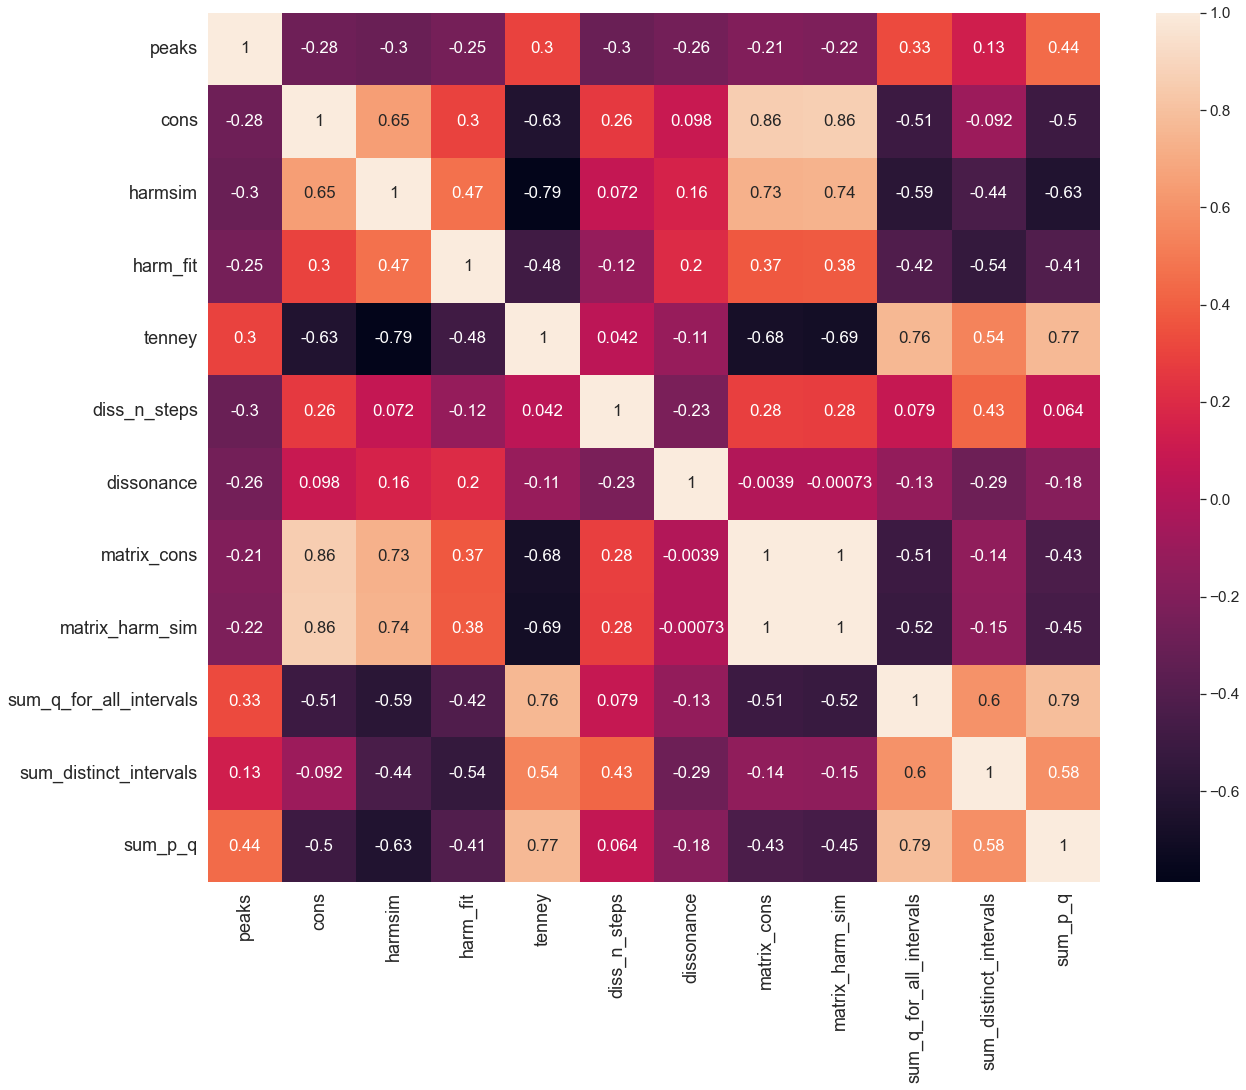

In [4]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='fixed', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)

df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
plt.show()

Let's do the same using Ensemble Empirical Mode Decomposition method (EEMD). 

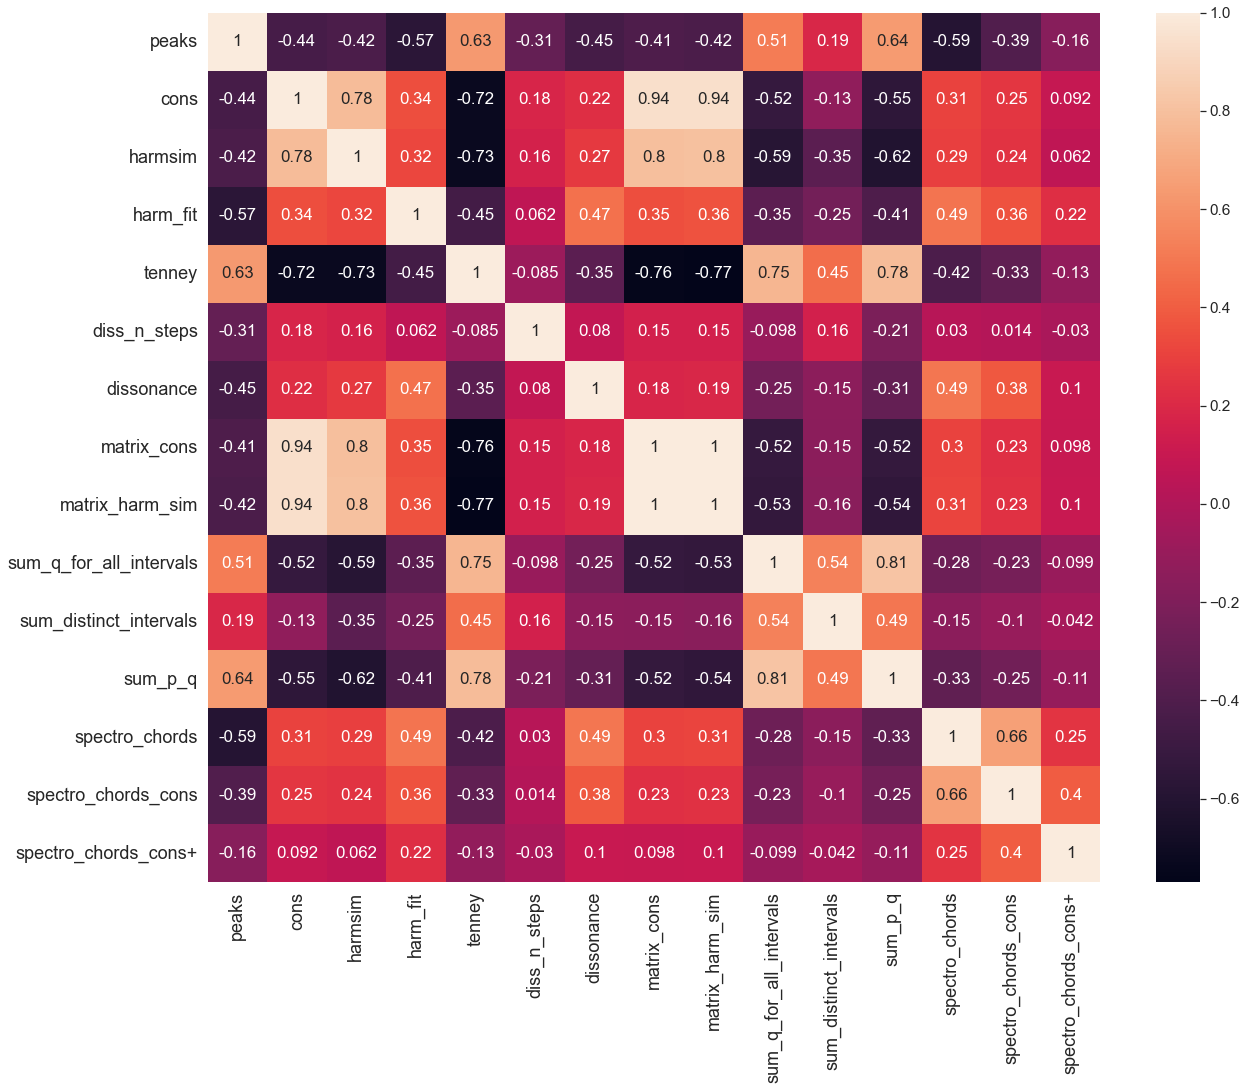

In [5]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='EEMD', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_metrics=True,
                             chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)
df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
plt.show()

Since this method uses dyadic filter bank (octave filter bank) to decompose the signal into Intrinsic Mode Functions, we expect that harmonicity metrics might have slightly higher scores as compared to other methods. To test this, we will **plot the average of all metrics for different peak extraction methods**.

The *compare_corr_metrics_peaks* function takes an array of *trials * time_series* and return two dataframes in the shape *peaks_functions * harmonicity_metrics* of the correlation  with the averaged peaks frequency (*df_peaks_tot*) and their associated p-values (*df_p_EEG*). 

It also returns a list of dataframes (one per peaks function) in the shape *harmonicity metrics * trials*. (*df_metrics_all*)

In [6]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['fixed', 'adapt', 'HH1D_max', 'harmonic_peaks', 'cepstrum', 'EMD', 'EEMD', 'FOOOF', 'FOOOF_EEMD']
df_peaks_EEG, df_p_EEG, df_metrics_EEG = compare_corr_metrics_peaks(EEG_data[0:250, 2000:5000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_metrics=False)

fixed
adapt
HH1D_max
harmonic_peaks
cepstrum
EMD
EEMD
FOOOF
FOOOF_EEMD


Then, we will plot the **average of all metrics correlation** to see if it varies **across peak extraction methods**

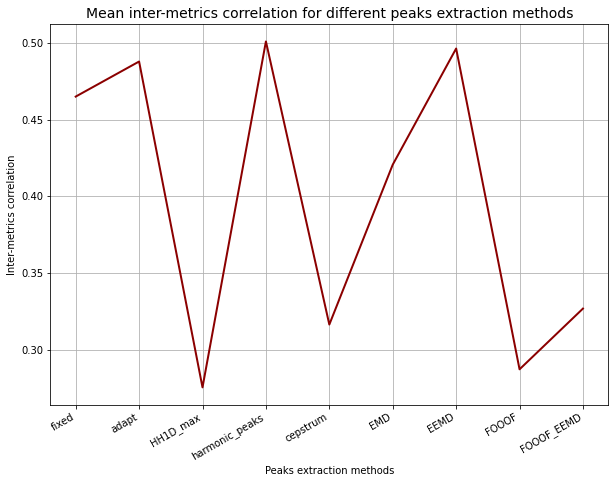

In [74]:
df_metrics_corr_avg = pd.DataFrame()
for i, method in enumerate(peaks_functions):
    df_metrics_corr_avg[peaks_functions[i]] = [np.average(abs(EEG_metrics_05.loc[method].iloc[:, 1:].corr()))]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.grid()
plt.show()
#df_metrics_corr_avg

We will do the same but with a peak precision of **0.1Hz** instead of 0.5Hz to see if the results are constant

In [ ]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['fixed', 'adapt', 'HH1D_max', 'harmonic_peaks', 'cepstrum', 'EMD', 'EEMD', 'FOOOF', 'FOOOF_EEMD']
df_peaks_EEG2, df_p_EEG2, df_metrics_EEG2 = compare_corr_metrics_peaks(EEG_data[0:250, 1000:9000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_metrics=False, 
                                                                      save=True, fname='EEG_metrics_0.1Hz_long')

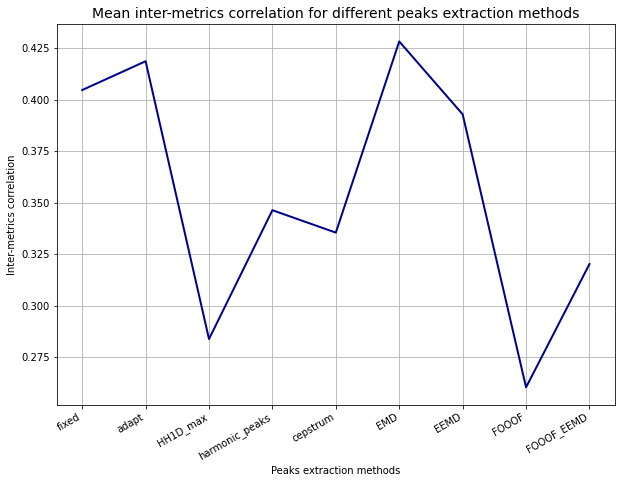

In [75]:
df_metrics_corr_avg = pd.DataFrame()
for i, method in enumerate(peaks_functions):
    df_metrics_corr_avg[peaks_functions[i]] = [np.average(abs(df_metrics_EEG2.loc[method].iloc[:, 1:].corr()))]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_metrics_corr_avg.loc[0], color='darkblue', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.grid()
plt.show()
#df_metrics_corr_avg

## How do harmonicity metrics are affected by averaged frequency values ?

Since the *Biotuner* computes hamonicity metrics on frequency peaks, we want to observe how these metrics correlate with the averaged frequency of their input. In other words, **are lower frequencies more consonant than higher frequencies ?** 

To answer this question, we will look at how the correlation between mean frequency and harmonicity metrics varies across peak extraction methods.

In [58]:
EEG_metrics_05 = pd.read_csv('EEG_metrics_0.5Hz.csv', index_col='index')
EEG_metrics_01 = pd.read_csv('EEG_metrics_0.1Hz_long.csv', index_col='index')
df_peaks_EEG_05 = pd.read_csv('EEG_metrics_0.5Hzpeaks_corr.csv', index_col='index')
df_peaks_EEG_01 = pd.read_csv('EEG_metrics_0.1Hzpeaks_corr.csv', index_col='index')
#df_sorted_EEG = df_peaks_EEG.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
#df_sorted_EEG = df_sorted_EEG #we remove the correlation of peaks with peaks (always equals 1)

<function matplotlib.pyplot.show(close=None, block=None)>

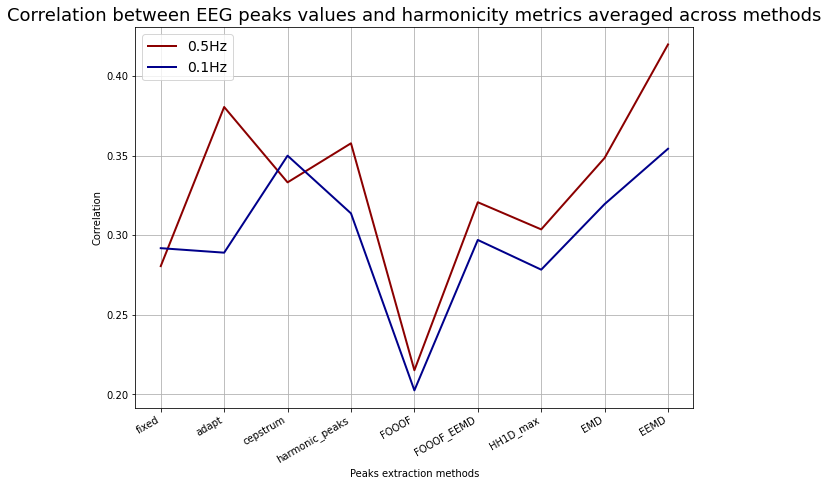

In [76]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_peaks_EEG_05.mean(axis=0), color = 'darkred', linewidth=2, label='0.5Hz')
plt.plot(df_peaks_EEG_01.mean(axis=0), color = 'darkblue', linewidth=2, label='0.1Hz')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Correlation')
plt.legend(fontsize=14)
plt.grid()
plt.show

Here we explore how harmonicity metrics correlate with frequency peaks in average of all peak extraction methods

<function matplotlib.pyplot.show(close=None, block=None)>

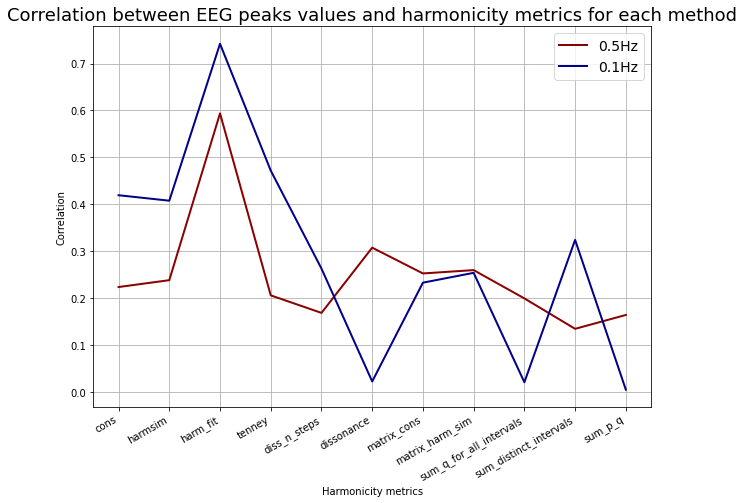

In [77]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(abs(EEG_metrics_05.corr().loc['peaks'][1:]), color = 'darkred', linewidth=2, label='0.5Hz')
plt.plot(abs(EEG_metrics_01.corr().loc['peaks'][1:]), color = 'darkblue', linewidth=2, label='0.1Hz')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.legend(fontsize=14)
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

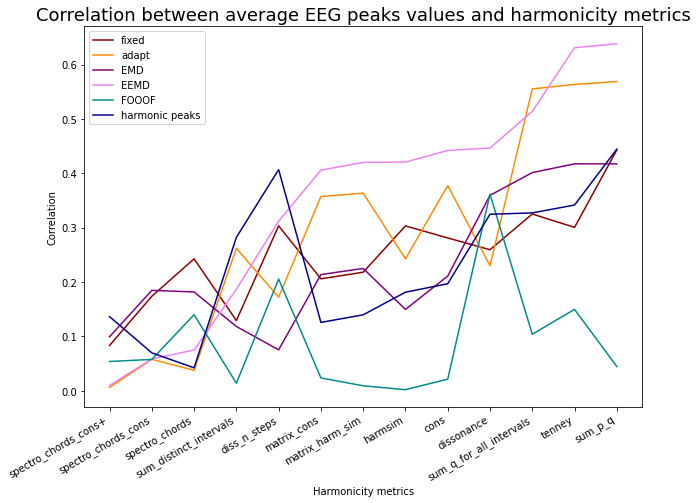

In [93]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EEG['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

## Which harmonicity metrics best distinguish between EEG and ECG ?

To answer this questions, we will compute the metrics for *n* trials for both EEG and ECG signals, using all the peaks extraction methods. 

To read a harmonicity metrics dataframe, use: 

*df_metrics = pd.read_csv(fname+'.csv', index_col='index')*

To read the *peaks_corr* and *peaks_p* dataframes, use:

*df_peaks_corr = pd.read_csv(fname+'peaks_corr.csv', index_col='index')*

In [3]:
#ECG
path = 'data_examples/ECG/'
data = mne.io.read_raw_edf(path + '/r01.edf', preload = True)
ECG_data = data.load_data()
ECG_data = ECG_data.get_data()
ECG_sf = 1000
ECG_data = slice_data(ECG_data[0:4], ECG_sf, window=5)
ECG_data.shape
EEG_data, ECG_data = equate_dimensions(EEG_data, ECG_data)


Extracting EDF parameters from C:\Users\Dell\GitHub\biotuner\examples\data_examples\ECG\r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


In [91]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions = ['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'FOOOF_EEMD', 'HH1D_max', 'EMD', 'EEMD']
peaks_corr_ECG, peaks_p_ECG, ECG_metrics = compare_corr_metrics_peaks(ECG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='ECG_metrics_0.5Hz')

peaks_corr_EEG, peaks_p_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='EEG_metrics_0.5Hz')


fixed
adapt
cepstrum
harmonic_peaks
FOOOF
FOOOF_EEMD
HH1D_max
EMD
EEMD
fixed
adapt
cepstrum
harmonic_peaks
FOOOF
FOOOF_EEMD
HH1D_max
EMD
EEMD


We will look at how the correlation between peak frequencies and harmonicity metrics differs between ECG and EEG.

We can see that values are comparable.

<function matplotlib.pyplot.show(close=None, block=None)>

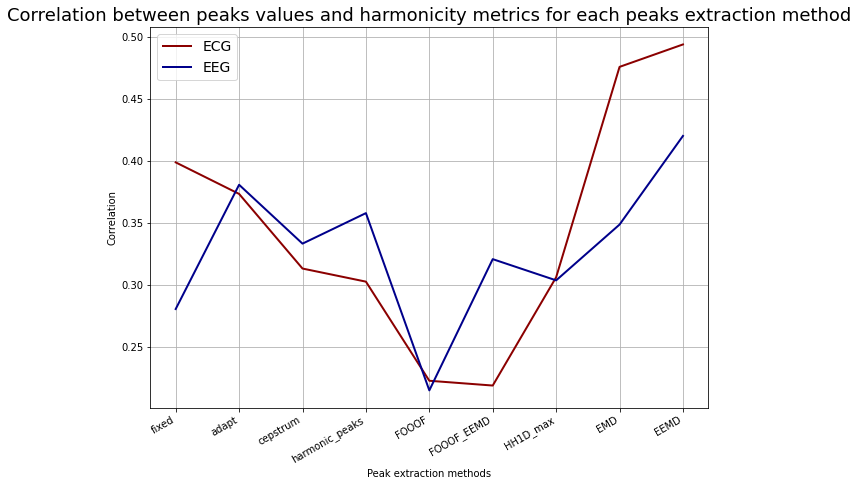

In [193]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=0), color = 'darkred', linewidth=2, label="ECG")
plt.plot(peaks_corr_EEG.mean(axis=0), color = 'darkblue', linewidth=2, label='EEG')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between peaks values and harmonicity metrics for each peaks extraction method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.legend(fontsize=14)
plt.grid()
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

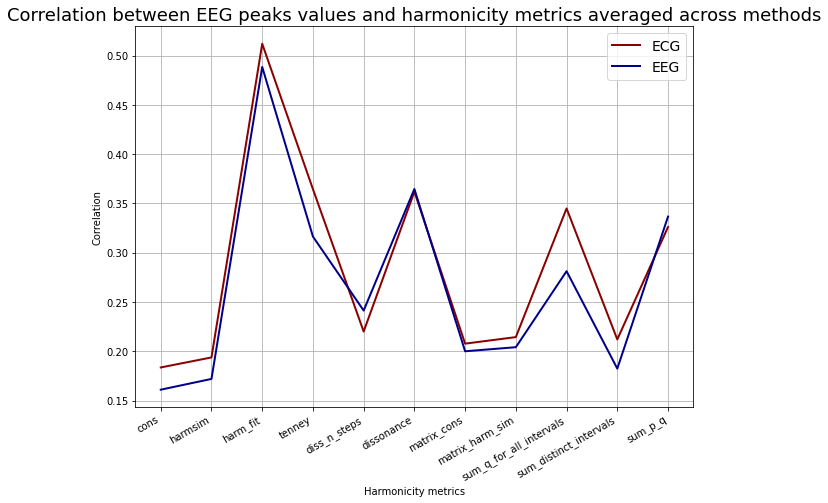

In [191]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=1)[1:], color = 'darkred', linewidth=2, label='ECG')
plt.plot(peaks_corr_EEG.mean(axis=1)[1:], color = 'darkblue', linewidth=2, label='EEG')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.grid()
plt.legend(fontsize=14)
plt.show

### We will evaluate with Analyses of Covariance (ANCOVA) which harmonicity metrics and peaks extraction functions best distinguish between ECG and EEG signals.

On the following graphs, the line corresponds to p values of the ANCOVA **comparing the two distributions for each harmonicity metric, while controlling for peaks frequencies**. The dots correspond to the *p value* of the correlation between each metric and the peak frequencies. The triangles appear only for metrics that are significant and their color indicate which data type (e.g. EEG or ECG) has higher mean value for the corresponding metric.

In [78]:
EEG_metrics = pd.read_csv('EEG_metrics_0.5Hz.csv', index_col='index')
peaks_p_EEG = pd.read_csv('EEG_metrics_0.5Hzpeaks_p.csv', index_col='index')
ECG_metrics = pd.read_csv('ECG_metrics_0.5Hz.csv', index_col='index')
peaks_p_ECG = pd.read_csv('ECG_metrics_0.5Hzpeaks_p.csv', index_col='index')

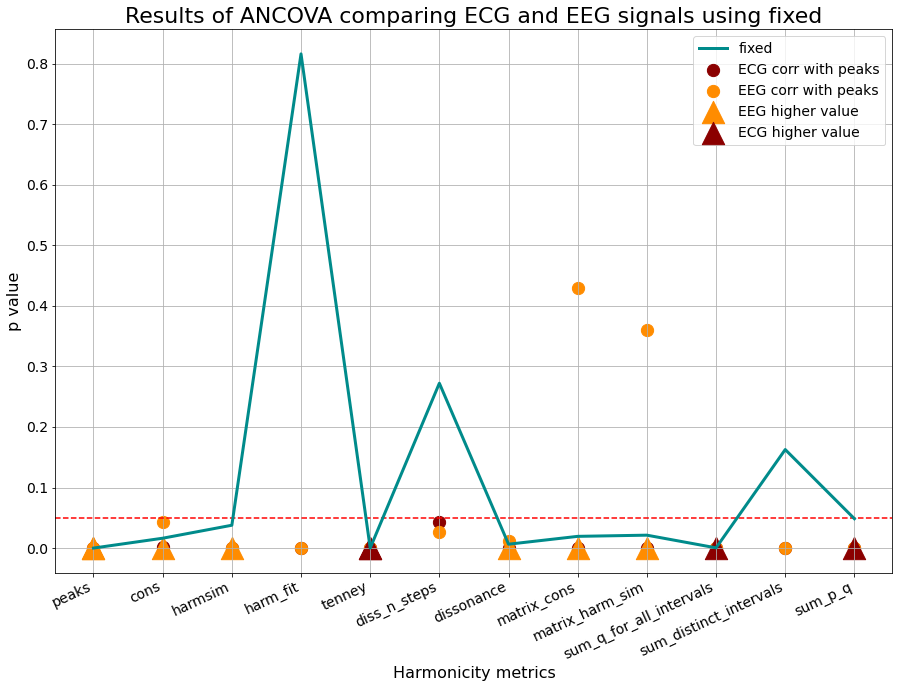

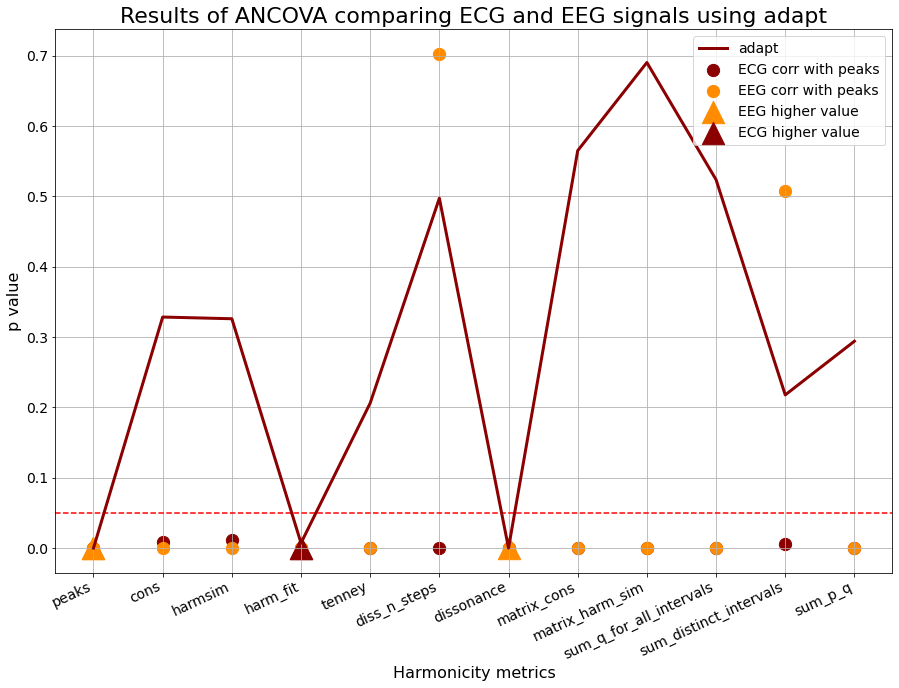

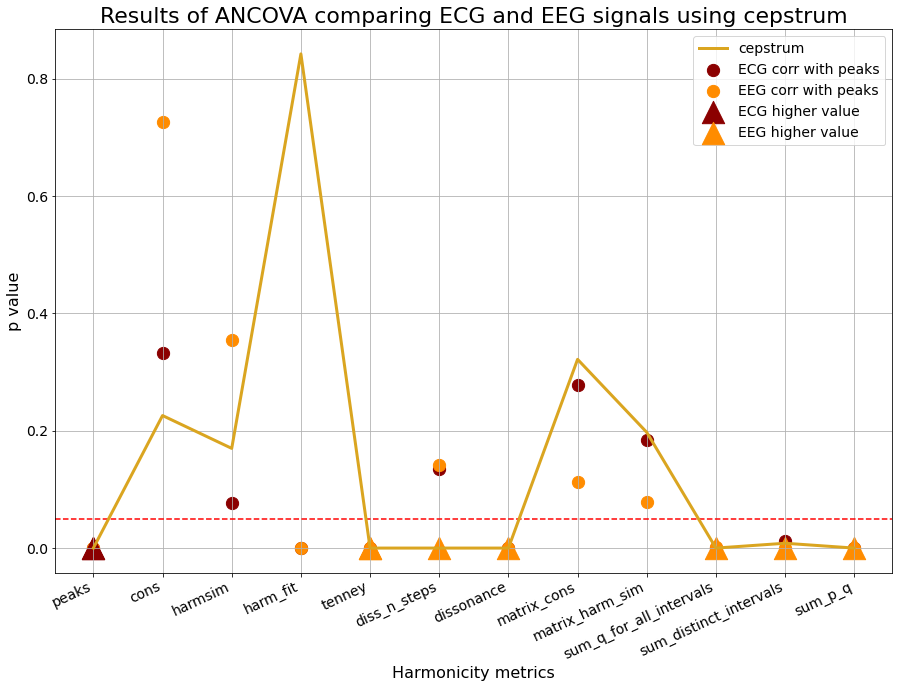

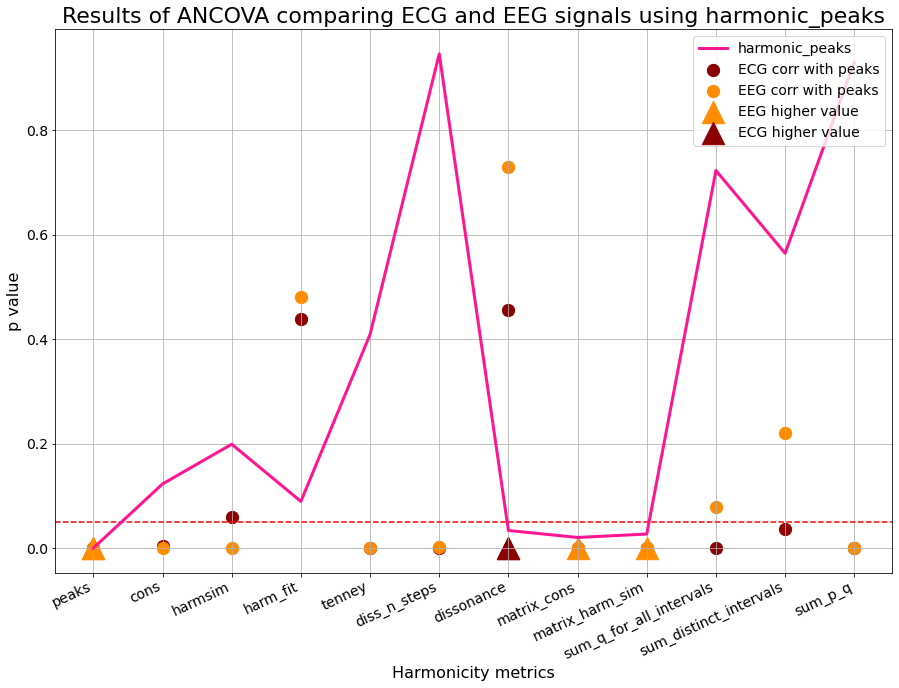

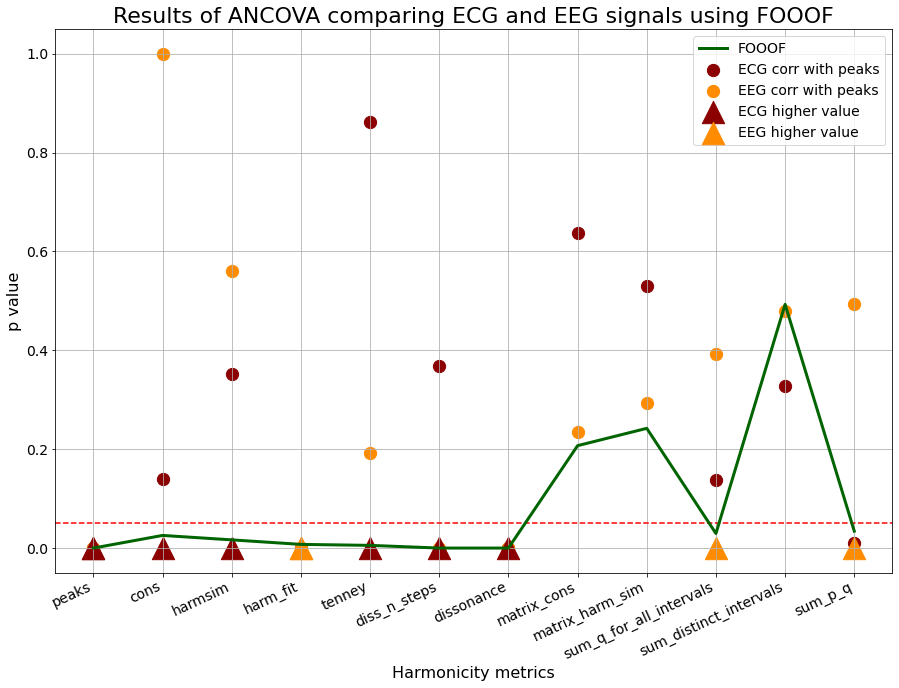

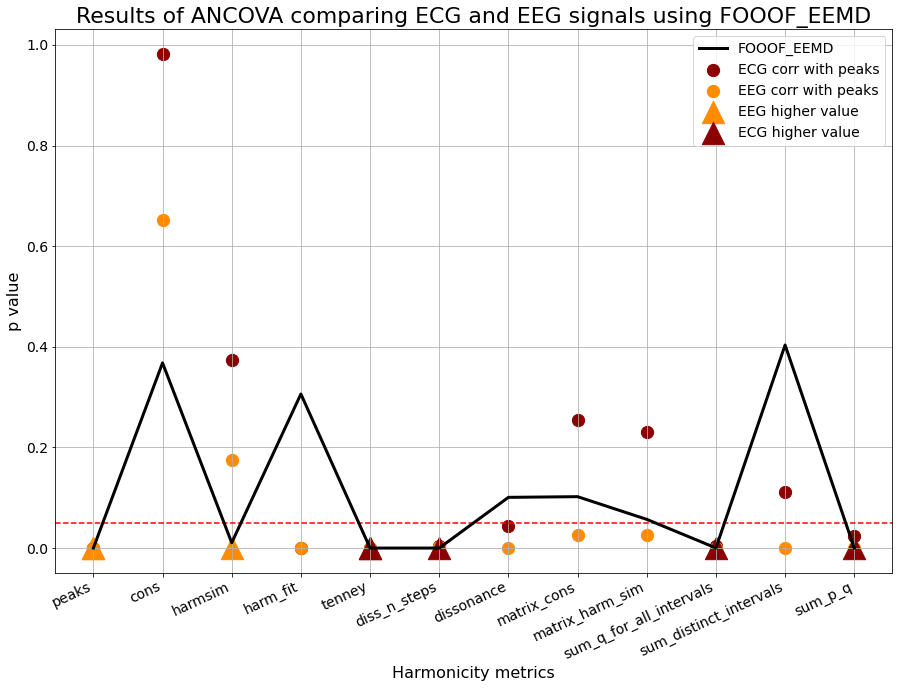

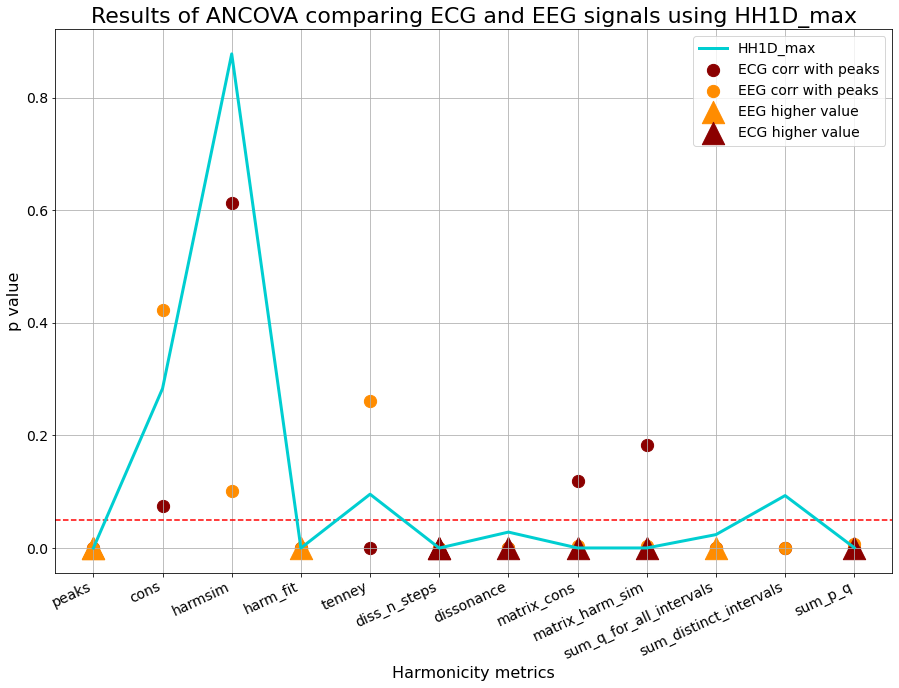

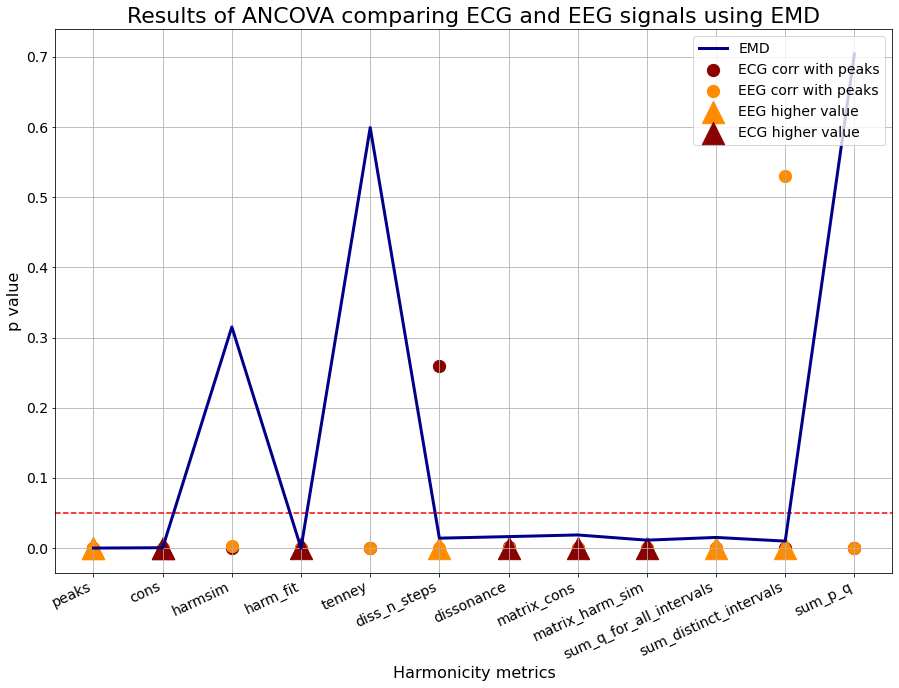

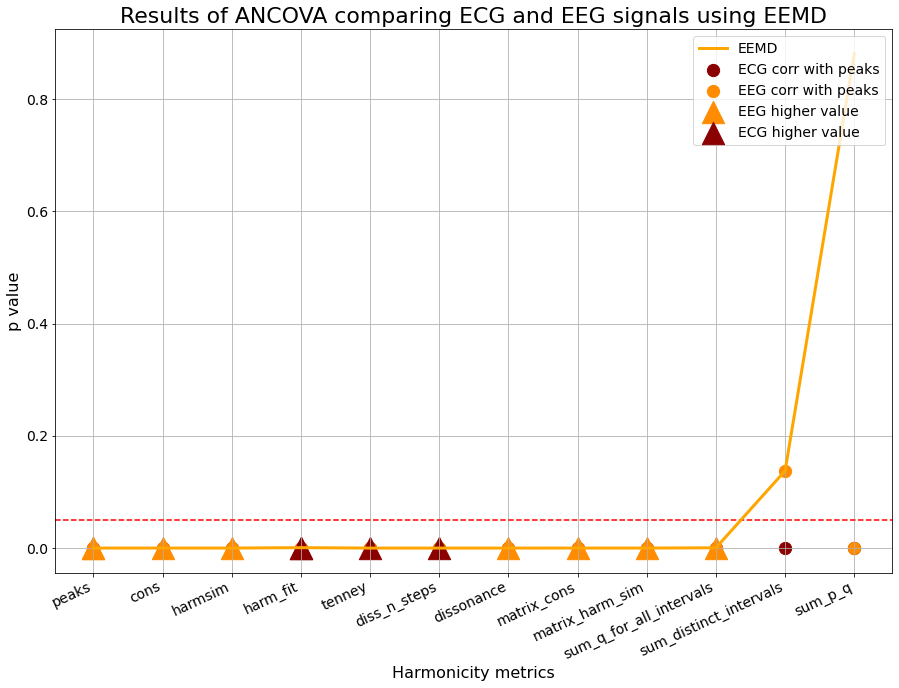

In [23]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(ECG_metrics, EEG_metrics, peaks_functions, data_types=['ECG', 'EEG'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['ECG', 'EEG'], 
                           peaks_corr1=peaks_p_ECG, peaks_corr2=peaks_p_EEG, color=color, save=True, avg_all=avg_all)

      Source        SS   DF          F         p-unc       np2
0  data_type  0.066706    1  18.903888  1.682397e-05  0.038197
1      peaks  0.204689    1  58.007402  1.418999e-13  0.108627
2   Residual  1.679646  476        NaN           NaN       NaN


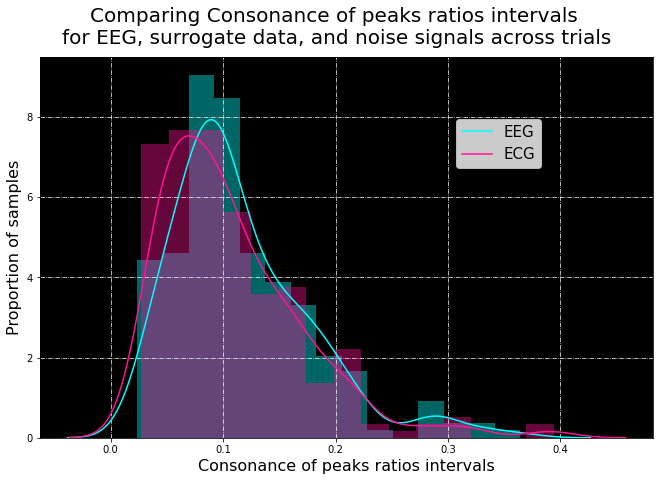

In [25]:
method ='EEMD'
metric='matrix_cons'
data_types=['EEG', 'ECG']
print(ancova_biotuner2d(EEG_metrics, ECG_metrics, method, metric, data_types, plot=False))

test_graph = [EEG_metrics.loc[method][metric], ECG_metrics.loc[method][metric]]
graph_dist(test_graph, metric = metric, ref = test_graph[0], dimensions = [0], labs = ['EEG', 'ECG'], 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = method, colors = None, display = True, save = False, title=None)

We will now compute the same analyses with metrics that are computed across the time axis: spectral chords. 
Spectral chords correspond to moments in time when Intrinsic Mode Functions (IMFs) derived from EEMD or Instantaneous Frequencies (IF) derived from Hilbert-Huang transform exhibit a level of consonance about a predetermined threshold

In [4]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions = ['HH1D_max', 'EMD', 'EEMD']
peaks_corr_ECG, peaks_p_ECG, ECG_metrics = compare_corr_metrics_peaks(ECG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=True, save=True, fname='ECG_metrics_0.5Hz_chords')

peaks_corr_EEG, peaks_p_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=True, save=True, fname='EEG_metrics_0.5Hz_chords')


HH1D_max
EMD
EEMD
HH1D_max
EMD
EEMD


In [6]:
EEG_metrics

peaks      cons    harmsim  harm_fit     tenney  diss_n_steps  \
HH1D_max  16.624  0.005487   0.508188        12  15.343024             2   
HH1D_max  13.586  0.004949   0.442536        13  16.135064             4   
HH1D_max  18.274  0.009674   0.692291        13  15.921207             2   
HH1D_max  16.602  0.011384   1.046046        18  15.366831             3   
HH1D_max  17.562  0.007907   0.739669         9  16.103094             5   
...          ...       ...        ...       ...        ...           ...   
EEMD      17.100  0.068045   7.040164        10   8.123459             6   
EEMD      16.700  0.284693  38.034188        10   5.405226             4   
EEMD      20.200  0.118004  11.935598         8   7.740887             4   
EEMD      21.100  0.310511  35.962302         7   5.091677             4   
EEMD      17.400  0.056501   6.430166         5   8.868423             4   

          dissonance  matrix_cons  matrix_harm_sim  sum_q_for_all_intervals  \
HH1D_max    0.393242     0.053642         3.129607               14649850.0   
HH1D_max    0.431331     0.057398         3.480030               16160631.0   
HH1D_max    0.449794     0.005111         0.509072               23735903.0   
HH1D_max    0.506228     0.010177         1.008252                7812730.0   
HH1D_max    0.839917     0.005832         0.580870                9880584.0   
...              ...          ...              ...                      ...   
EEMD        0.785281     0.041219         4.025031                   9519.0   
EEMD        0.882760     0.218939        19.440270                   1311.0   
EEMD        0.733369     0.064032         6.071168                  16155.0   
EEMD        0.648714     0.184306        16.929581                   1541.0   
EEMD        0.328830     0.034422         3.350405                  39298.0   

          sum_distinct_intervals  sum_p_q  IF_chords  spectro_chords  
HH1D_max                    90.0  11773.0       80.0             NaN  
HH1D_max                    86.0  11115.0       60.0             NaN  
HH1D_max                    90.0  13444.0       54.0             NaN  
HH1D_max                    82.0   9065.0       52.0             NaN  
HH1D_max                    80.0  10388.0       83.0             NaN  
...                          ...      ...        ...             ...  
EEMD                        26.0    699.0        NaN           591.0  
EEMD                        24.0    131.0        NaN           665.0  
EEMD                        70.0    599.0        NaN           528.0  
EEMD                        32.0    157.0        NaN           503.0  
EEMD                        66.0    927.0        NaN           459.0  

[720 rows x 14 columns]

In [5]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(ECG_metrics, EEG_metrics, peaks_functions, data_types=['ECG', 'EEG'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['ECG_chords', 'EEG_chords'], 
                           peaks_corr1=peaks_p_ECG, peaks_corr2=peaks_p_EEG, color=color, save=True, avg_all=avg_all)

ValueError: negative dimensions are not allowed

## Which harmonicity metrics best distinguish between EEG and pink noise ?

In [3]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/EEG_pareidolia/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

In [15]:
pink_data = surrogate_signal_matrices(EEG_data[0:240, 2000:7000], surr_type = 'pink', low_cut = 0.5, high_cut = 150, sf = 1000)

In [51]:
EEG_metrics = pd.read_csv('EEG_metrics_0.5Hz.csv', index_col='index')
peaks_p_eeg = pd.read_csv('EEG_metrics_0.5Hzpeaks_p.csv', index_col='index')
pink_metrics = pd.read_csv('pink_metrics_0.5Hz.csv', index_col='index')
peaks_p_pink = pd.read_csv('pink_metrics_0.5Hzpeaks_p.csv', index_col='index')

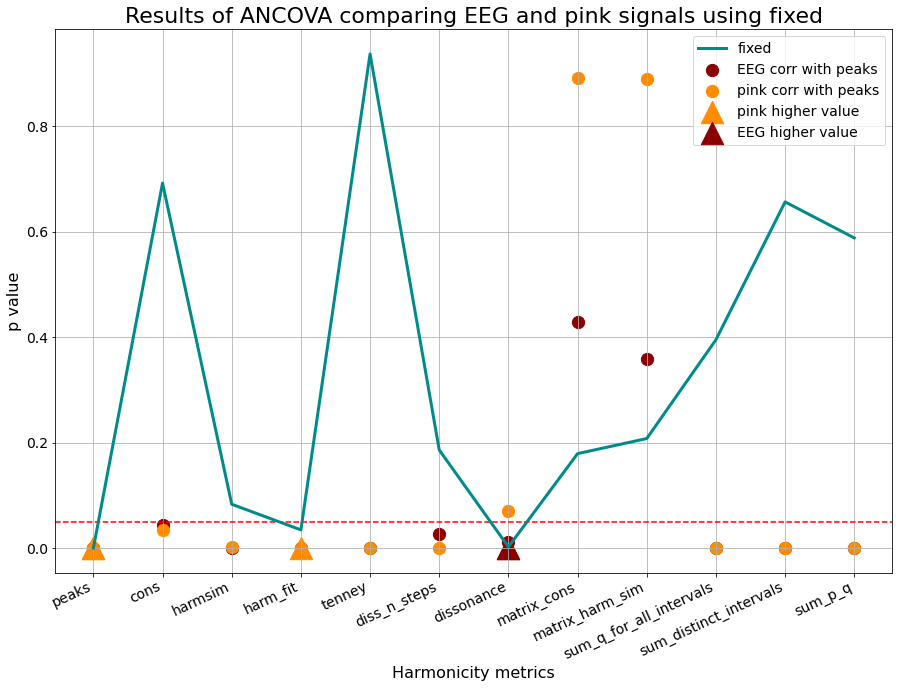

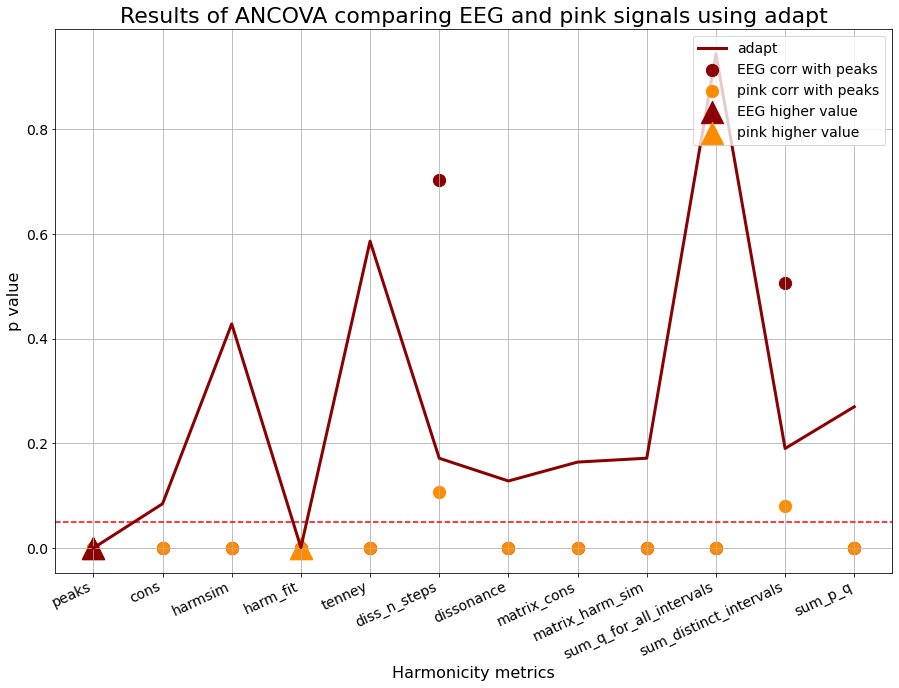

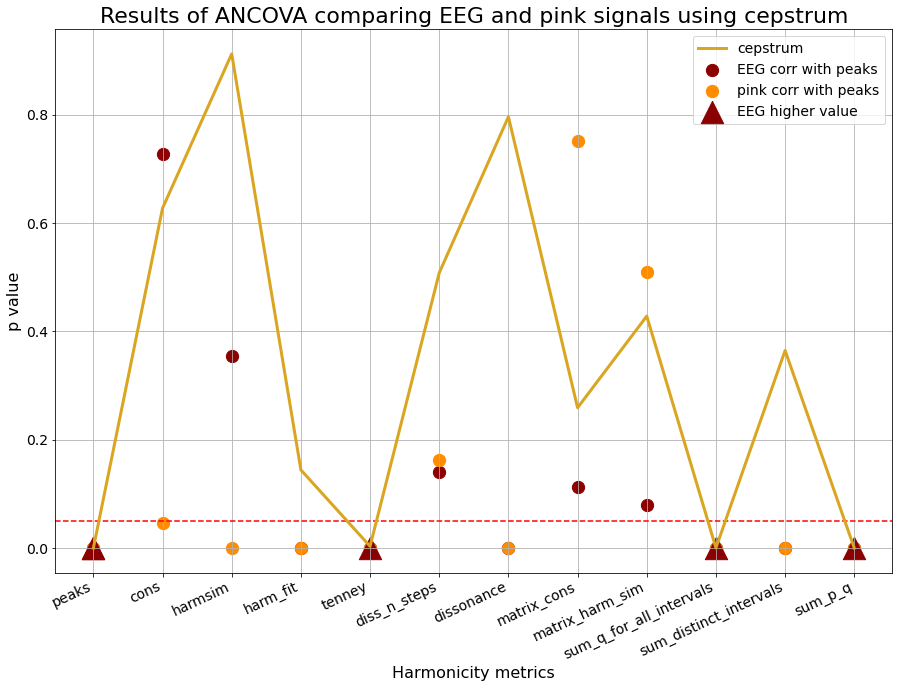

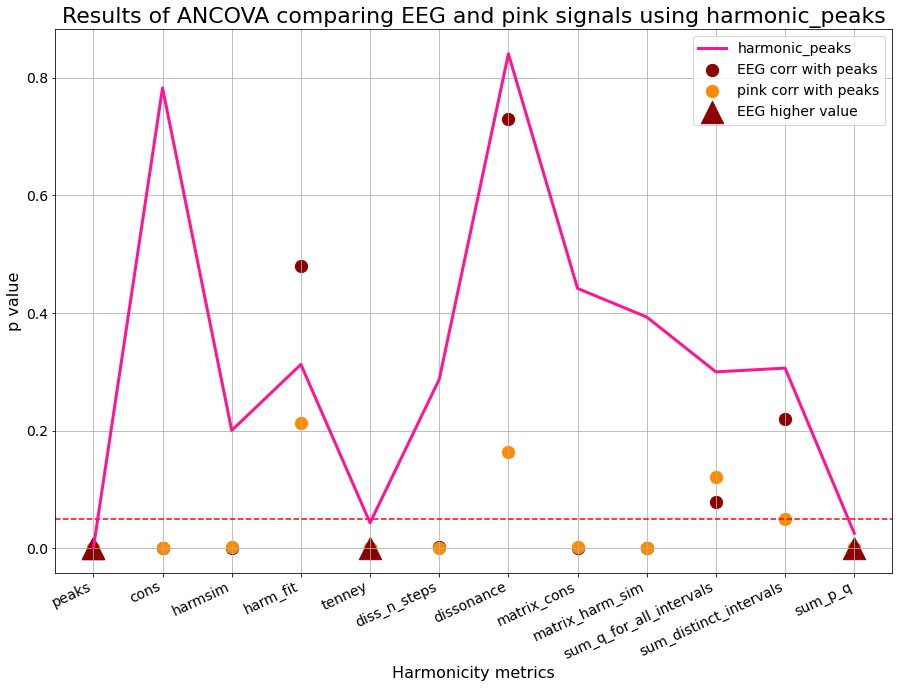

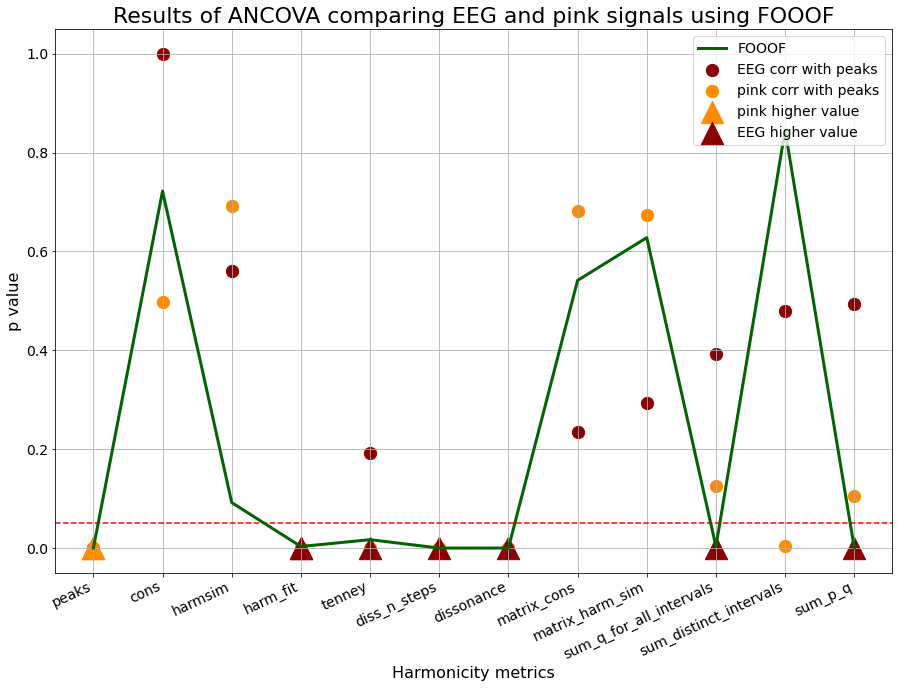

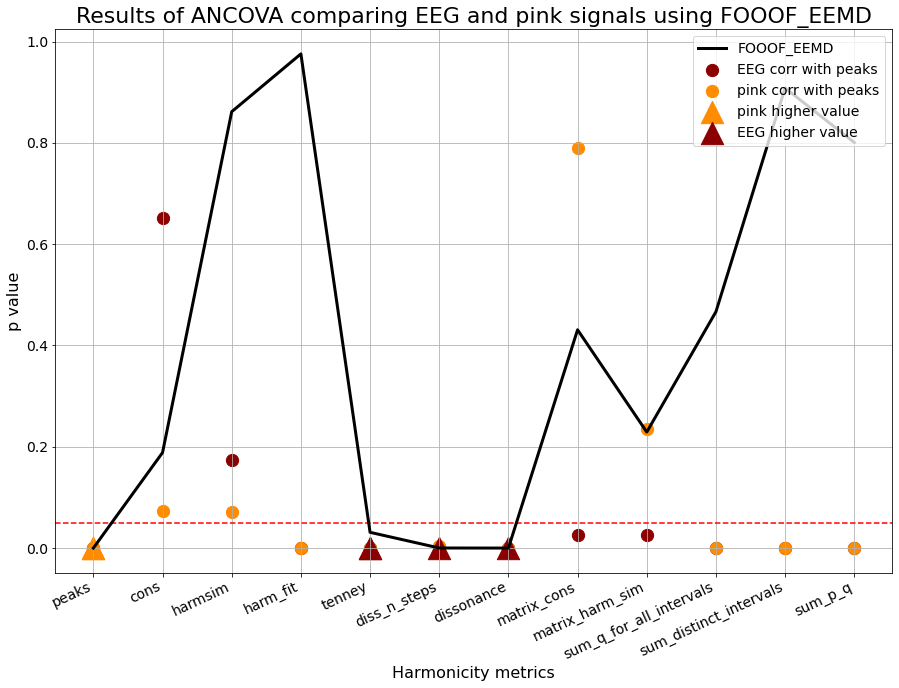

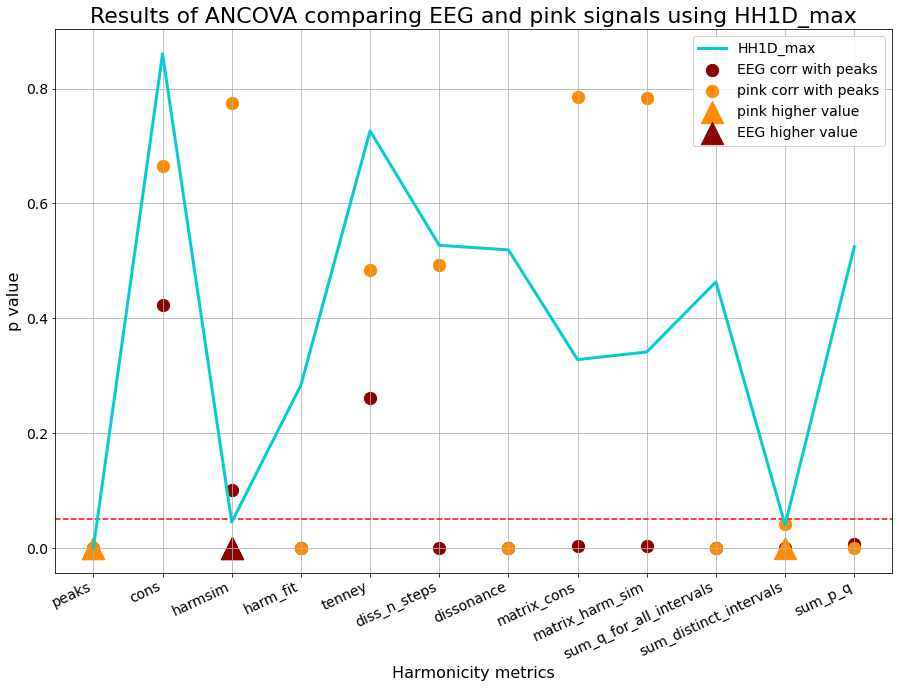

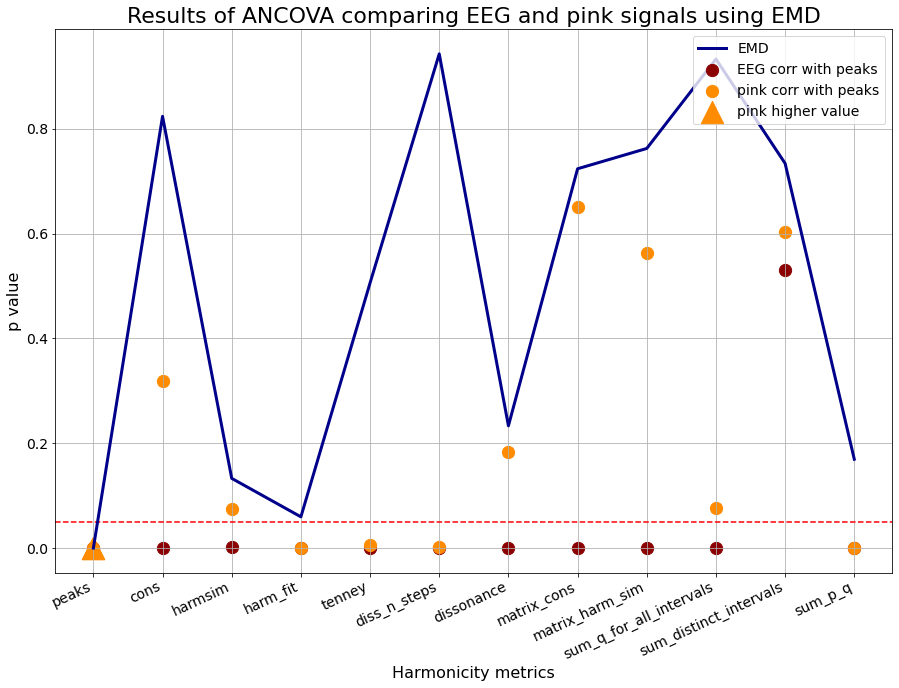

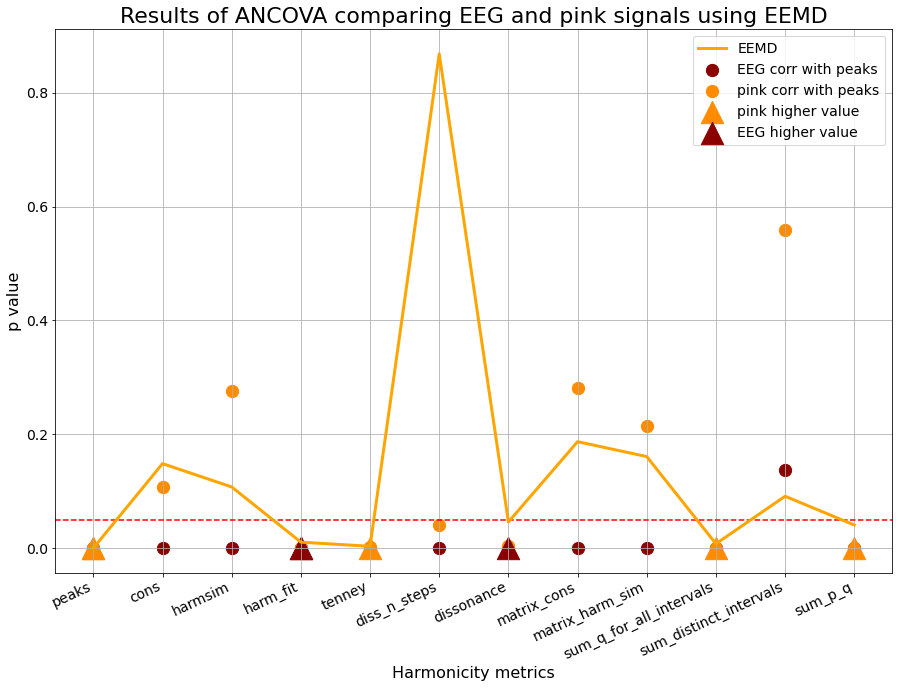

In [52]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, pink_metrics, 
                                                            peaks_functions, data_types=['EEG', 'pink'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'pink'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_pink, color=color, save=True, avg_all=avg_all)

      Source           SS   DF           F         p-unc       np2
0  data_type    29.610553    1    6.618196  1.039555e-02  0.013685
1      peaks   507.840155    1  113.506353  6.403207e-24  0.192219
2   Residual  2134.151512  477         NaN           NaN       NaN


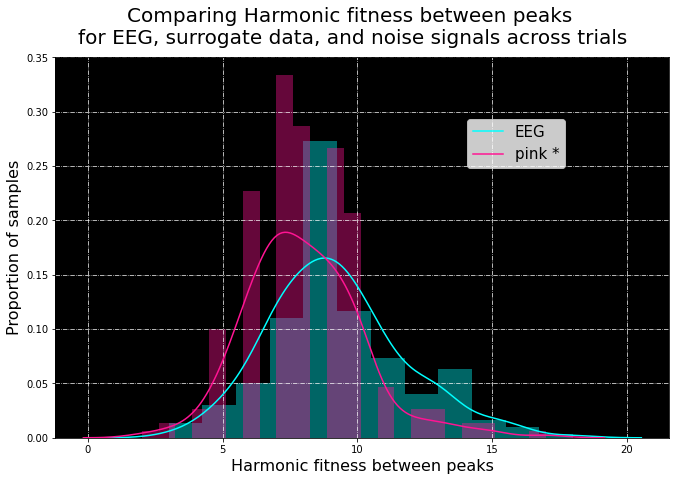

In [54]:
method ='EEMD'
metric='harm_fit'
data_types=['EEG', 'pink']
print(ancova_biotuner2d(EEG_metrics, pink_metrics, method, metric, data_types, plot=False))

test_graph = [EEG_metrics.loc[method][metric], pink_metrics.loc[method][metric]]
graph_dist(test_graph, metric = metric, ref = test_graph[0], dimensions = [0], labs = ['EEG', 'pink'], 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = method, colors = None, display = True, save = False, title=None)

## Which harmonicity metrics best distinguish between EEG and surrogate data ?

#### PHASE INFORMATION RANDOMIZATION

In [24]:
phase_data = surrogate_signal_matrices(EEG_data[0:240, 2000:7000], surr_type = 'phase', low_cut = 0.5, high_cut = 150, sf = 1000)

In [28]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'HH1D_max', 'FOOOF', 'FOOOF_EEMD', 'EMD', 'EEMD']
peaks_corr_phase, peaks_p_phase, phase_metrics = compare_corr_metrics_peaks(phase_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='phase_metrics_0.5Hz')



fixed
adapt
cepstrum
harmonic_peaks
HH1D_max
FOOOF
FOOOF_EEMD
EMD
EEMD


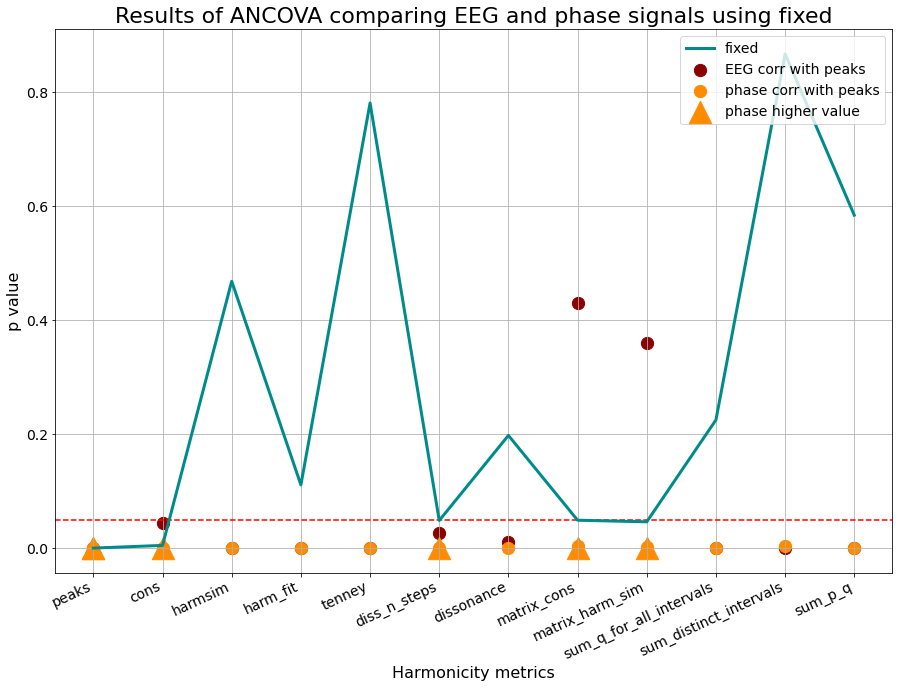

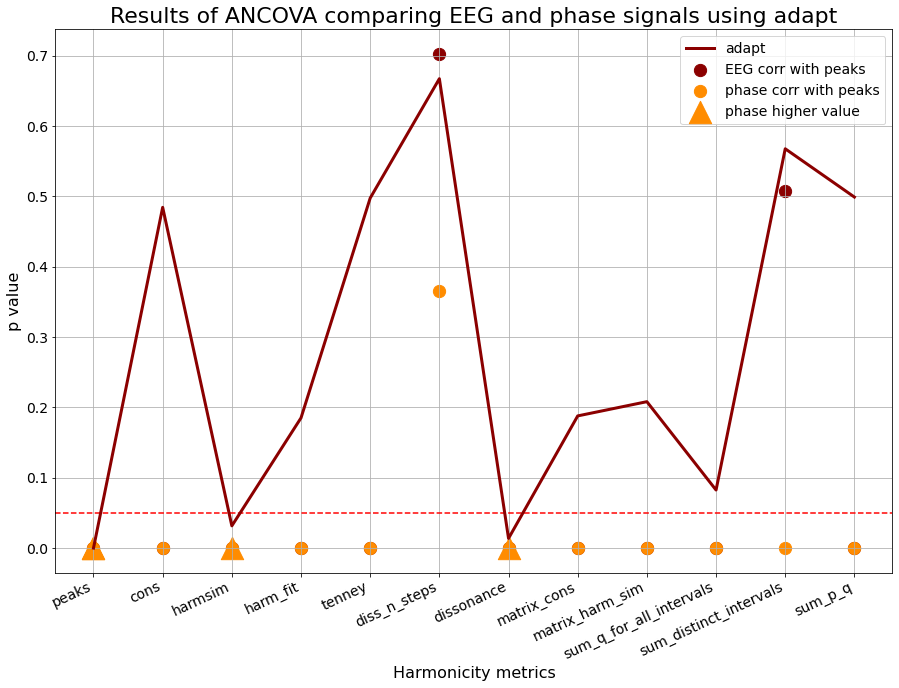

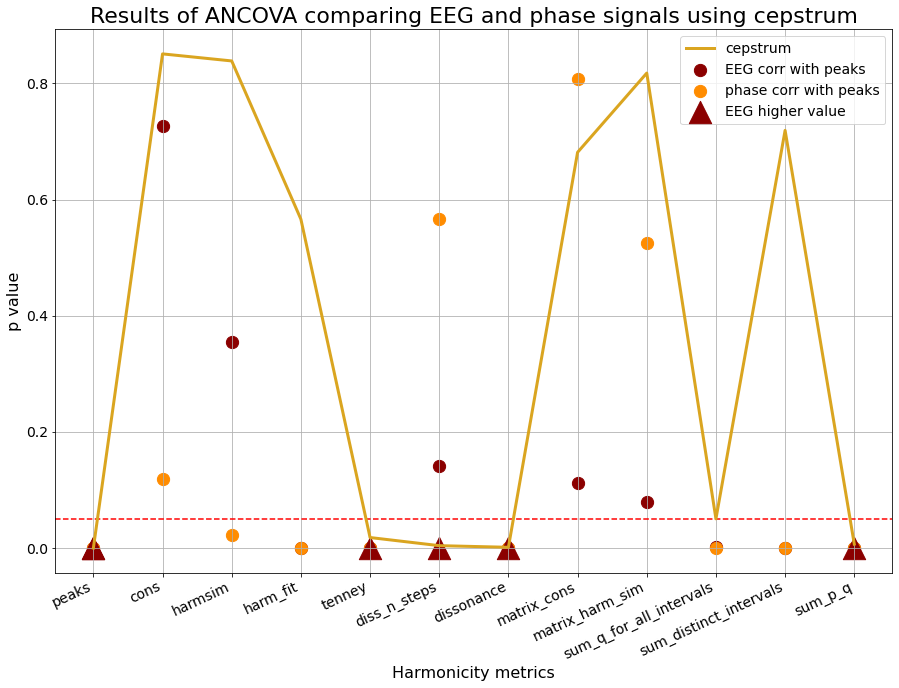

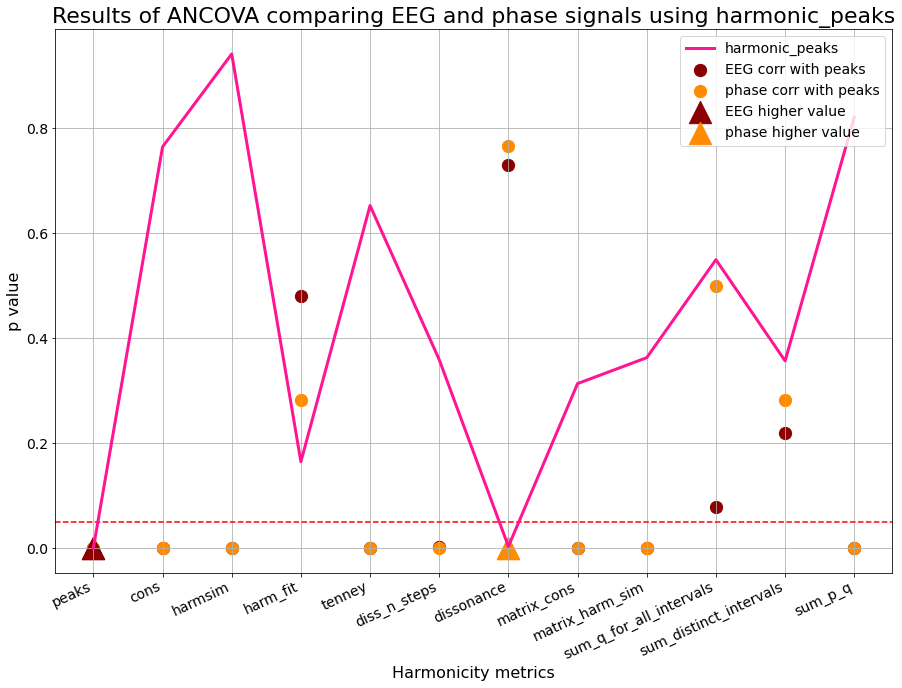

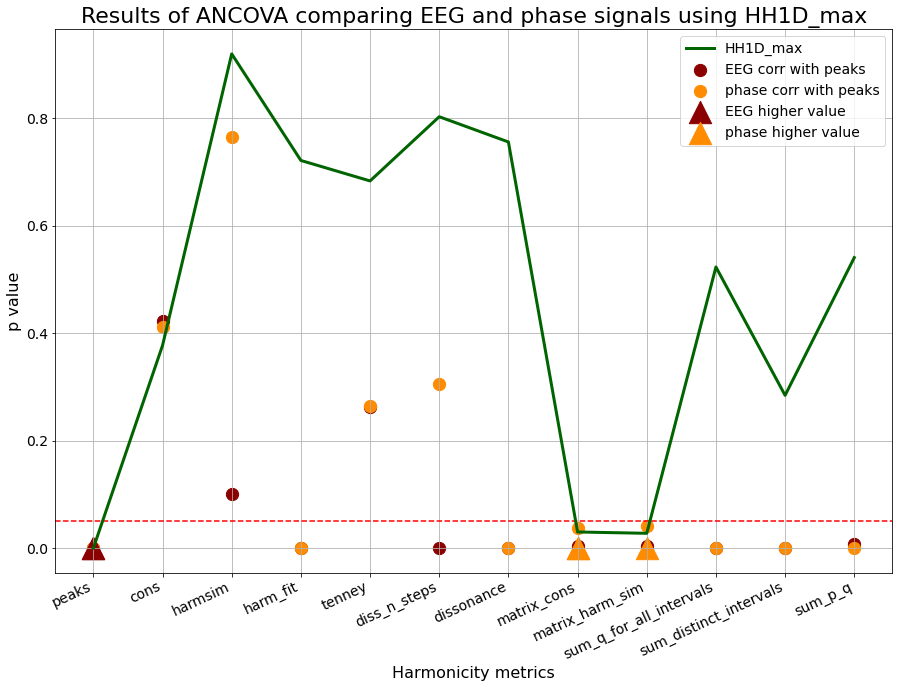

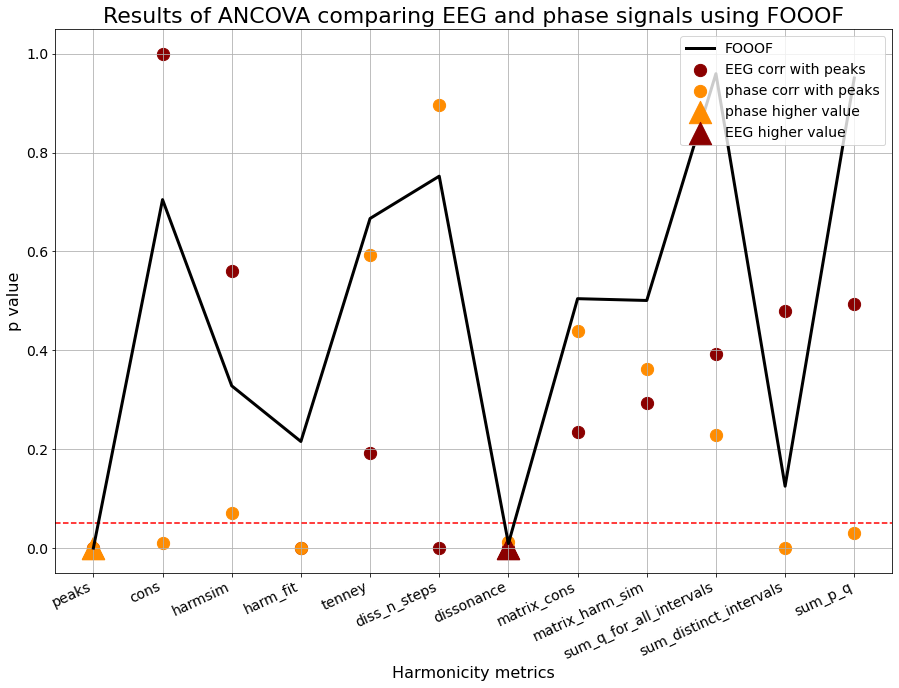

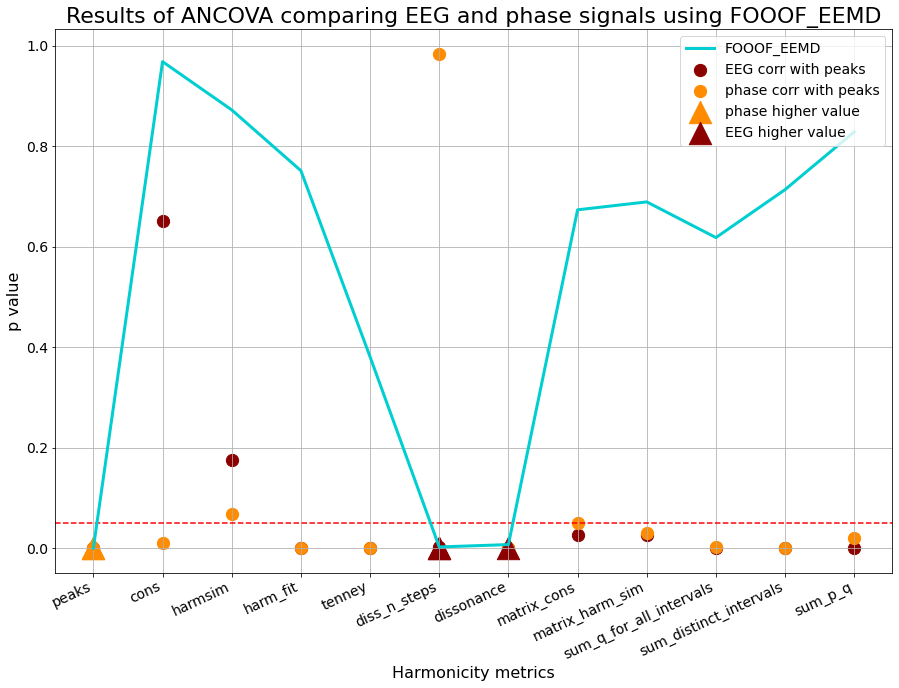

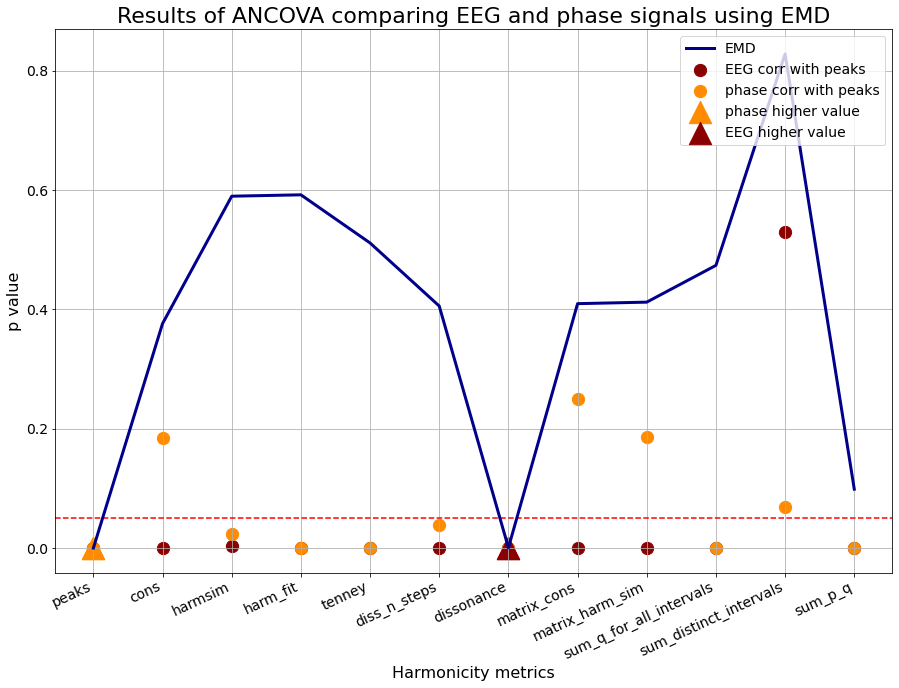

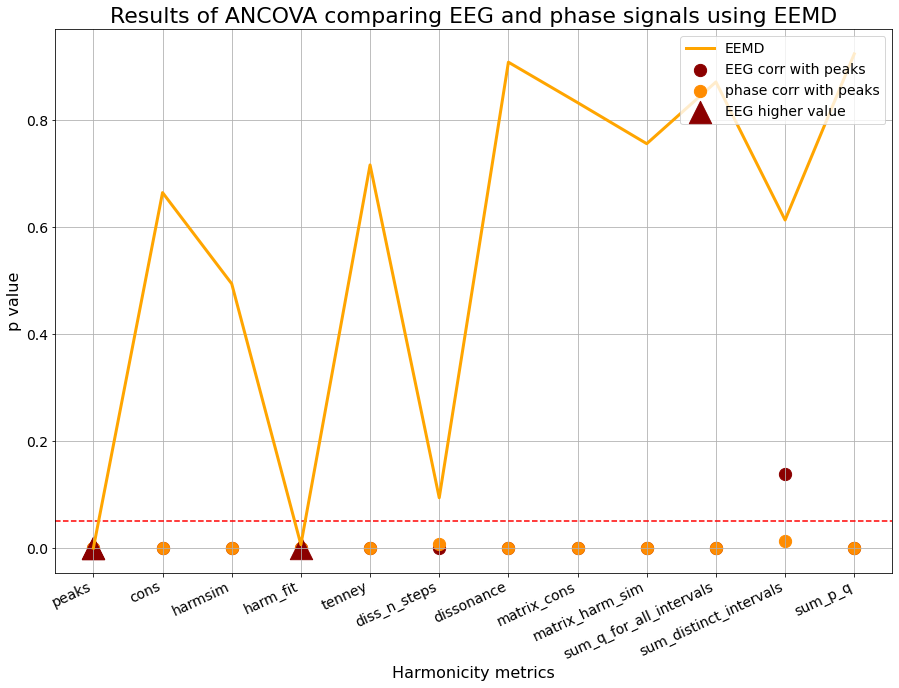

In [31]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, phase_metrics, 
                                                            peaks_functions, data_types=['EEG', 'phase'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'phase'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_phase, color=color, save=True, avg_all=avg_all)

### Amplitude adjusted Fourier Transform (AAFT)

In [3]:
AAFT_data = surrogate_signal_matrices(EEG_data[0:240, 2000:7000], surr_type = 'AAFT', low_cut = 0.5, high_cut = 150, sf = 1000)

In [ ]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'HH1D_max', 'FOOOF', 'FOOOF_EEMD', 'EMD', 'EEMD']
peaks_corr_AAFT, peaks_p_AAFT, AAFT_metrics = compare_corr_metrics_peaks(AAFT_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='AAFT_metrics_0.1Hz')



fixed
adapt
cepstrum
harmonic_peaks
HH1D_max


In [26]:
AAFT_metrics = pd.read_csv('AAFT_metrics_0.5Hz.csv', index_col='index')
peaks_p_AAFT = pd.read_csv('AAFT_metrics_0.5Hzpeaks_p.csv', index_col='index')

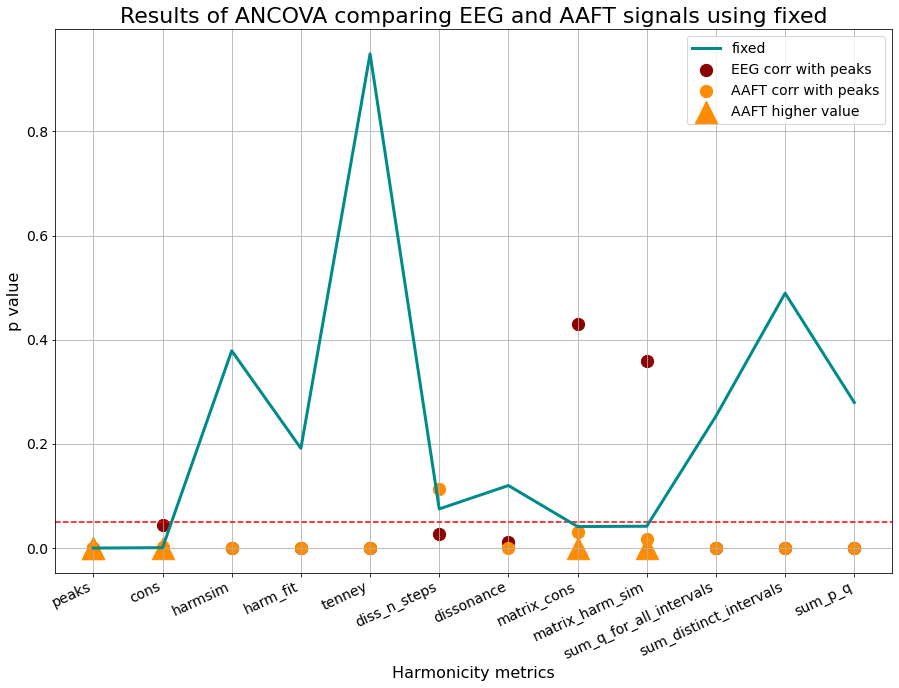

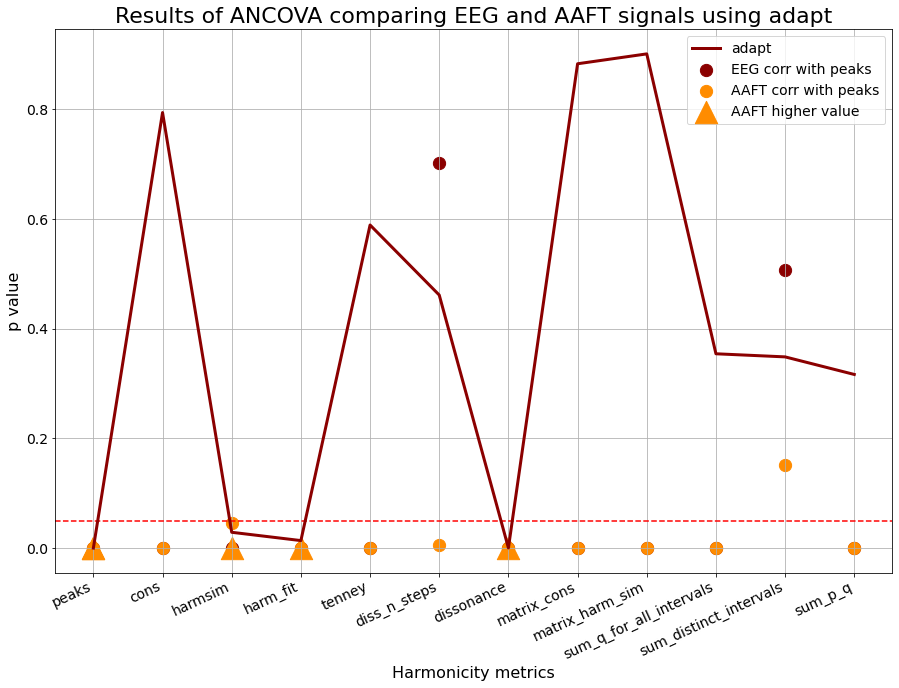

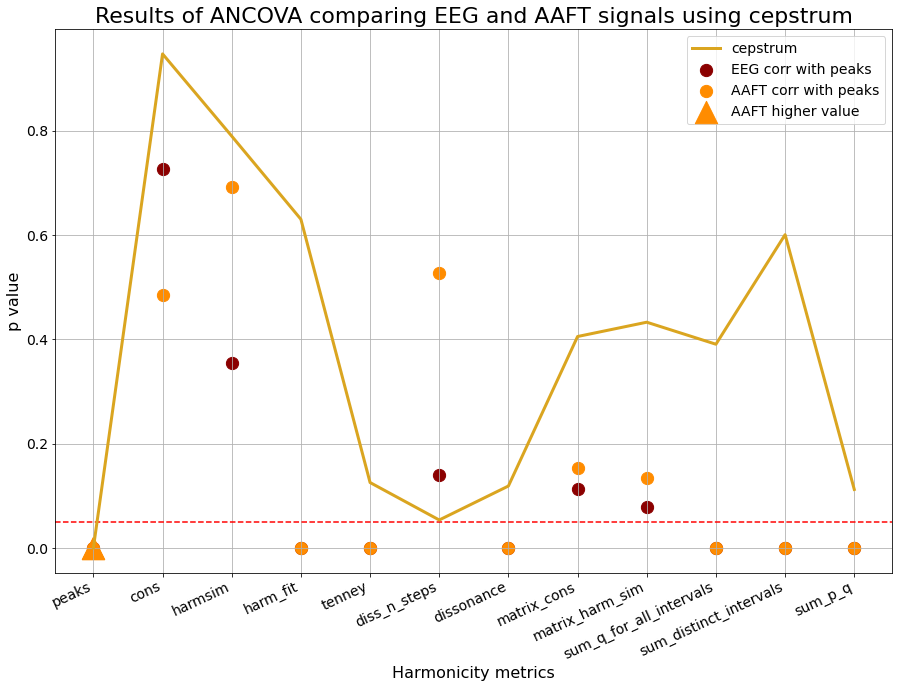

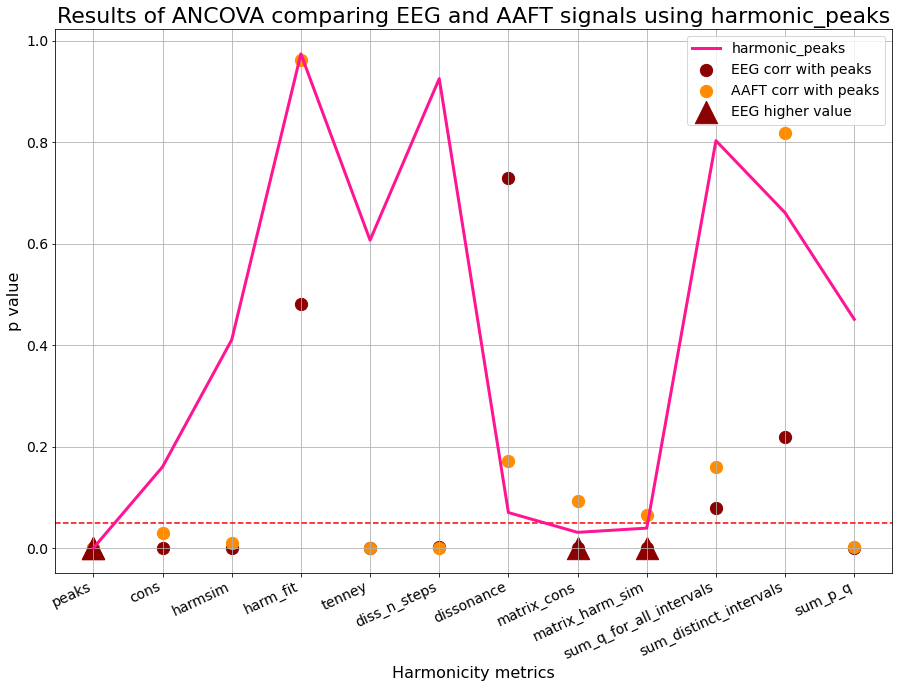

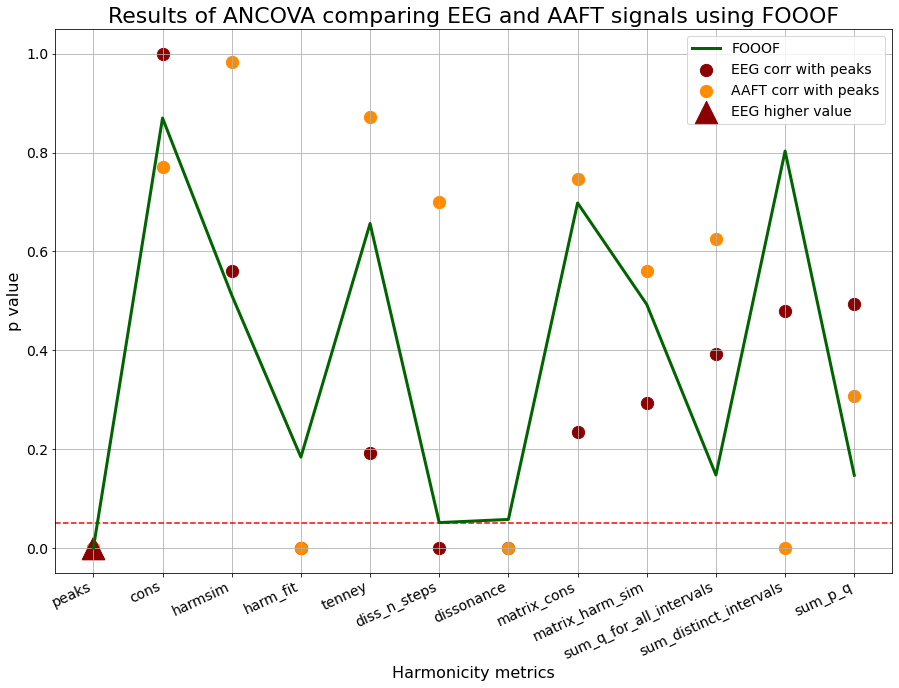

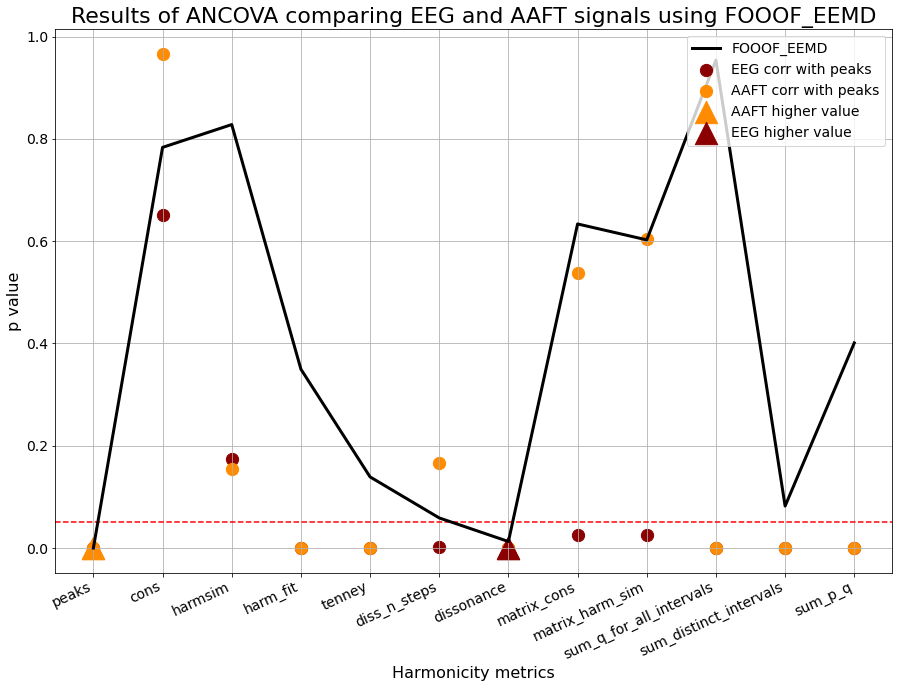

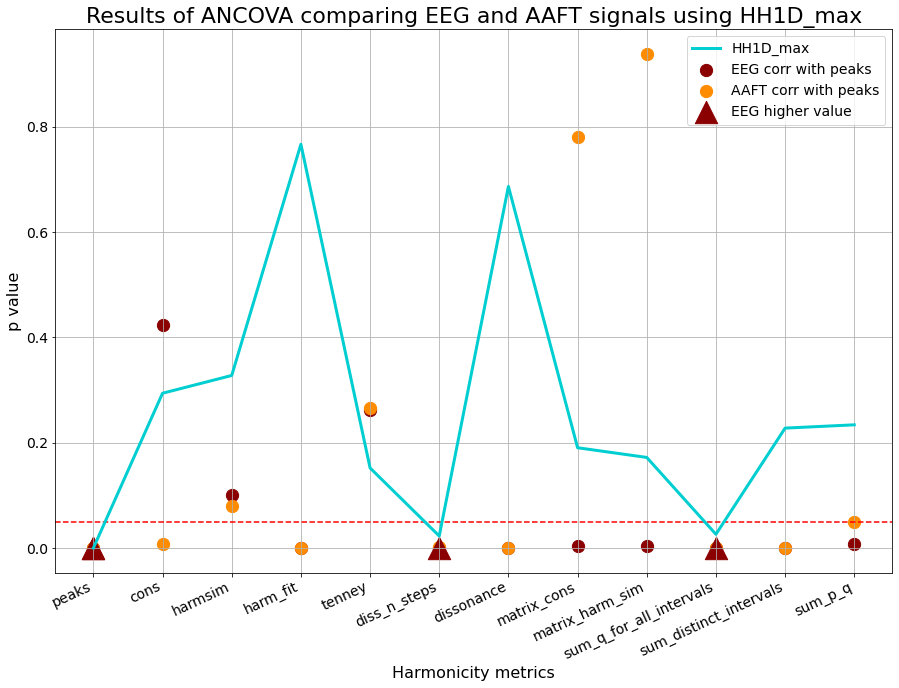

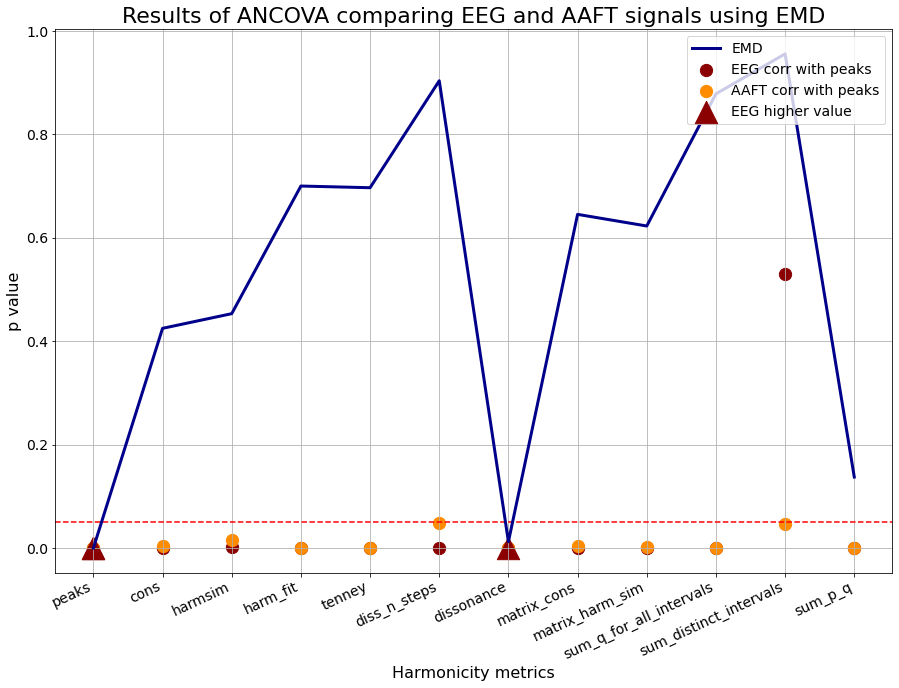

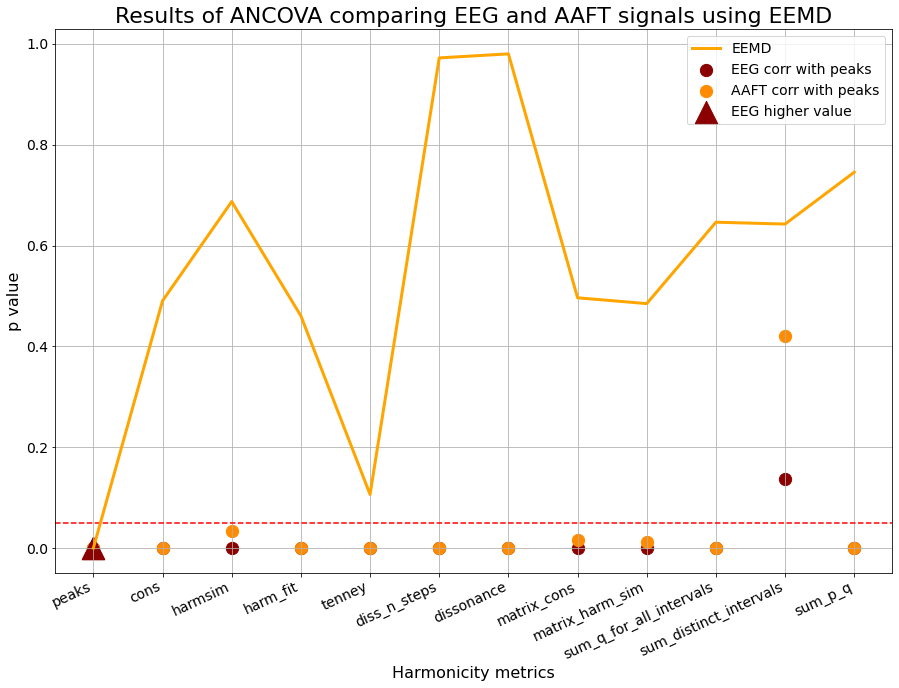

In [27]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, AAFT_metrics, 
                                                            peaks_functions, data_types=['EEG', 'AAFT'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'AAFT'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_AAFT, color=color, save=True, avg_all=avg_all)

We can observe that even if distributions are not significantly different using t-test, when controlling for peaks frequencies, the ANCOVA reveals a significant difference. 

      Source            SS   DF          F     p-unc       np2
0  data_type    232.748366    1   4.289410  0.039318  0.015929
1      peaks    904.084400    1  16.661721  0.000059  0.059155
2   Residual  14379.208767  265        NaN       NaN       NaN


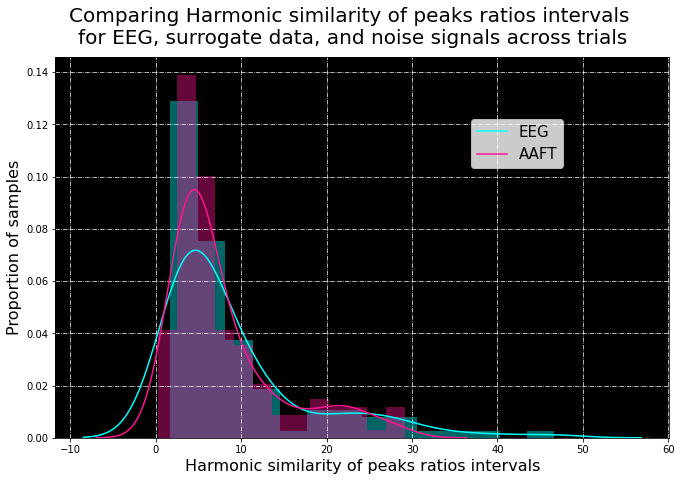

In [58]:
method ='harmonic_peaks'
metric='matrix_harm_sim'
data_types=['EEG', 'AAFT']
print(ancova_biotuner2d(EEG_metrics, AAFT_metrics, method, metric, data_types, plot=False))

test_graph = [EEG_metrics.loc[method][metric], AAFT_metrics.loc[method][metric]]
graph_dist(test_graph, metric = metric, ref = test_graph[0], dimensions = [0], labs = data_types, 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = method, colors = None, display = True, save = False, title=None)

## Comparing pareidolia vs non-pareidolia in the visual cortex

In [3]:
par_data = np.load('data_examples/EEG_pareidolia/parei_occi_L.npy')
nopar_data = np.load('data_examples/EEG_pareidolia/no_parei_occi_L.npy')

par_data, nopar_data = equate_dimensions(par_data, nopar_data)

par_data.shape, nopar_data.shape

((138, 5000), (138, 5000))

In [4]:
peaks_functions = ['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'HH1D_max', 'EMD', 'EEMD']
peaks_corr_par, peaks_p_par, par_metrics = compare_corr_metrics_peaks(par_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = None,
                                                          chords_metrics=False, save=True,
                                                                     fname='par_0.5Hz_')
peaks_corr_nopar, peaks_p_nopar, nopar_metrics = compare_corr_metrics_peaks(nopar_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = None,
                                                          chords_metrics=False, save=True, 
                                                                            fname='nopar_0.5Hz_')


fixed
adapt
cepstrum
harmonic_peaks
FOOOF
HH1D_max
EMD
EEMD
fixed
adapt
cepstrum
harmonic_peaks
FOOOF
HH1D_max
EMD
EEMD


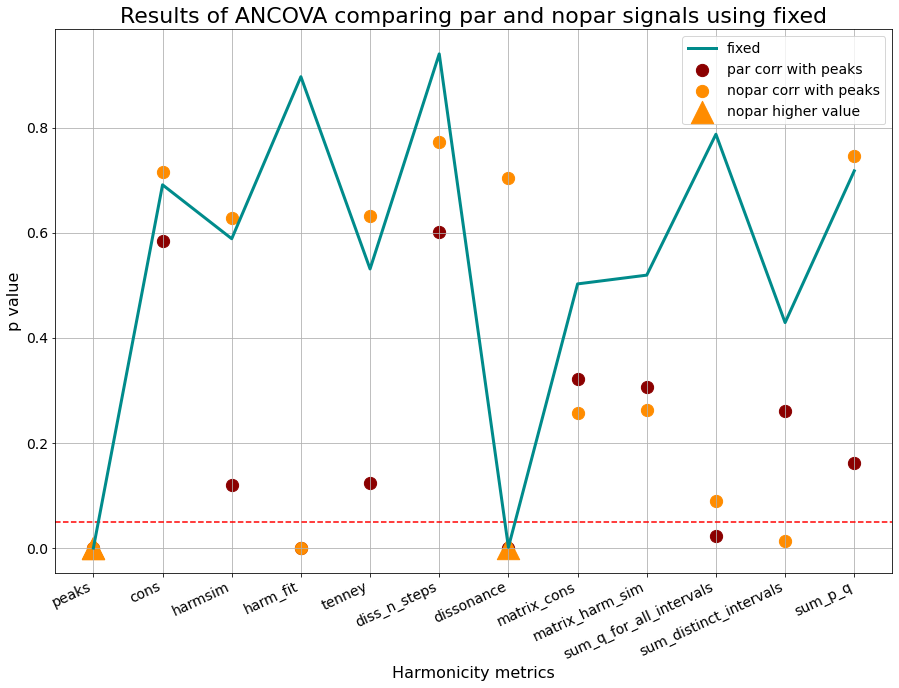

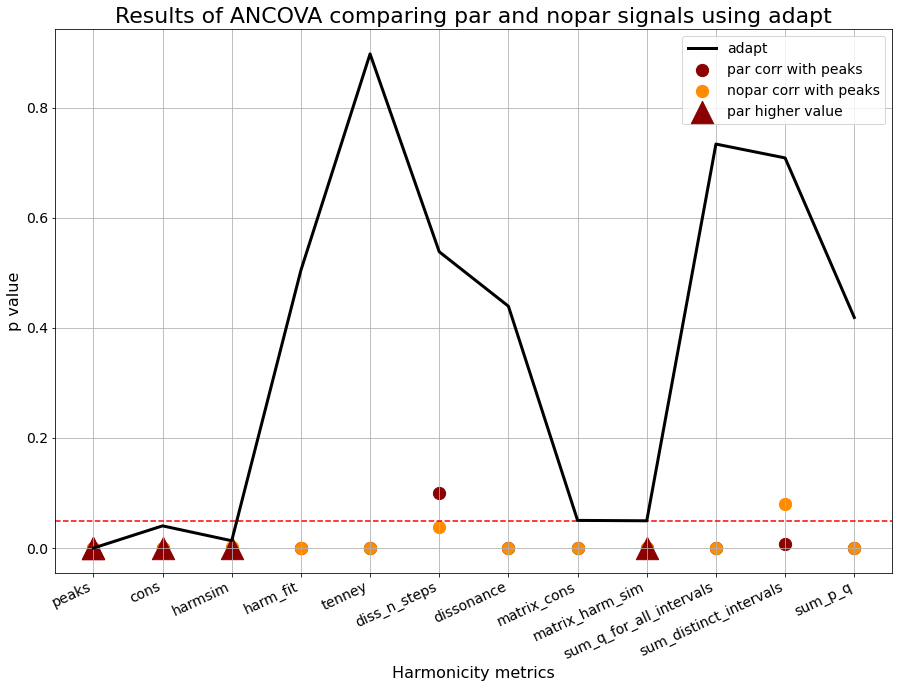

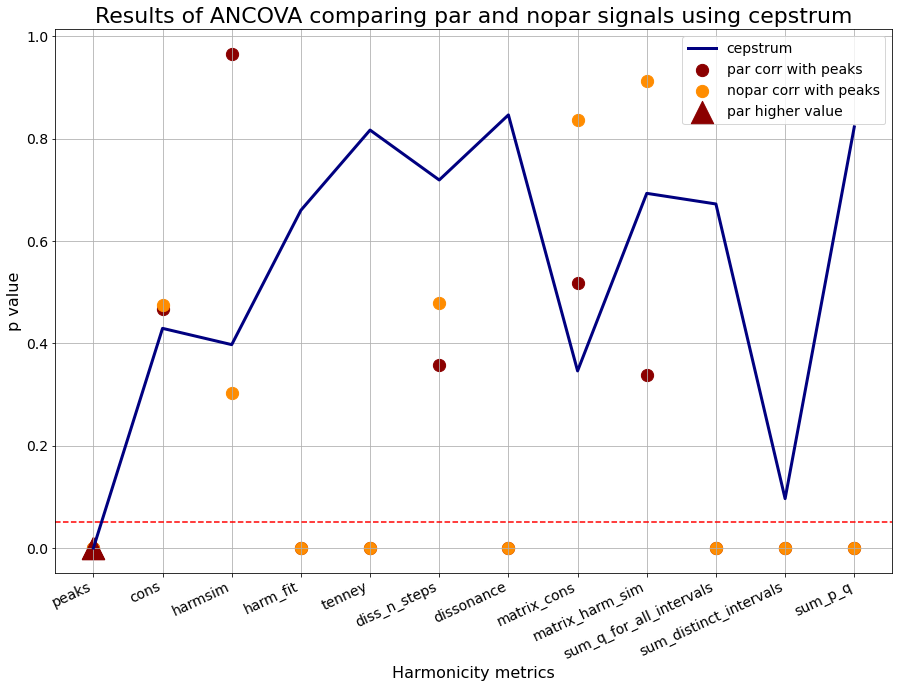

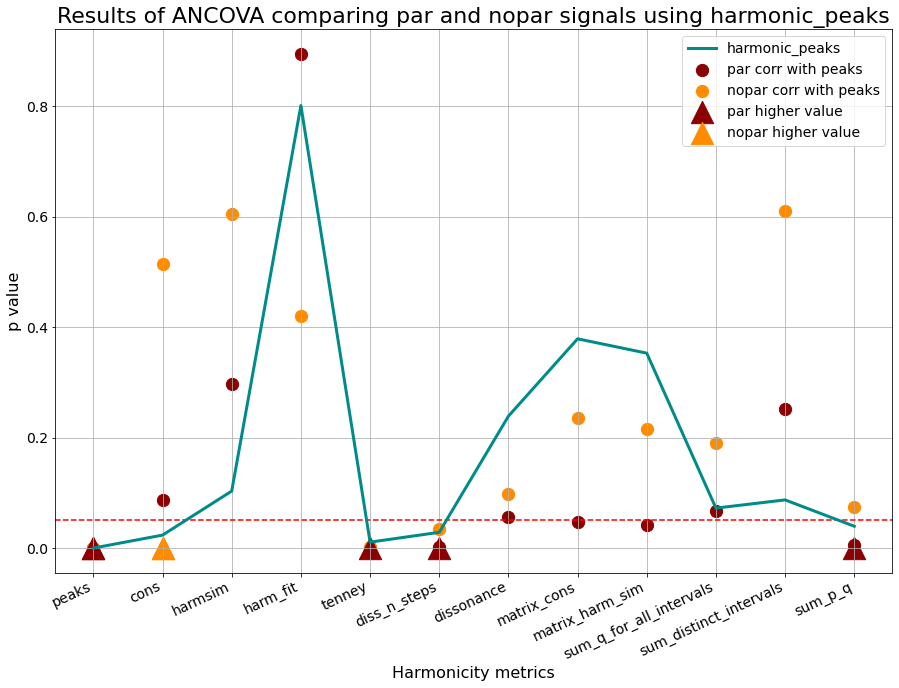

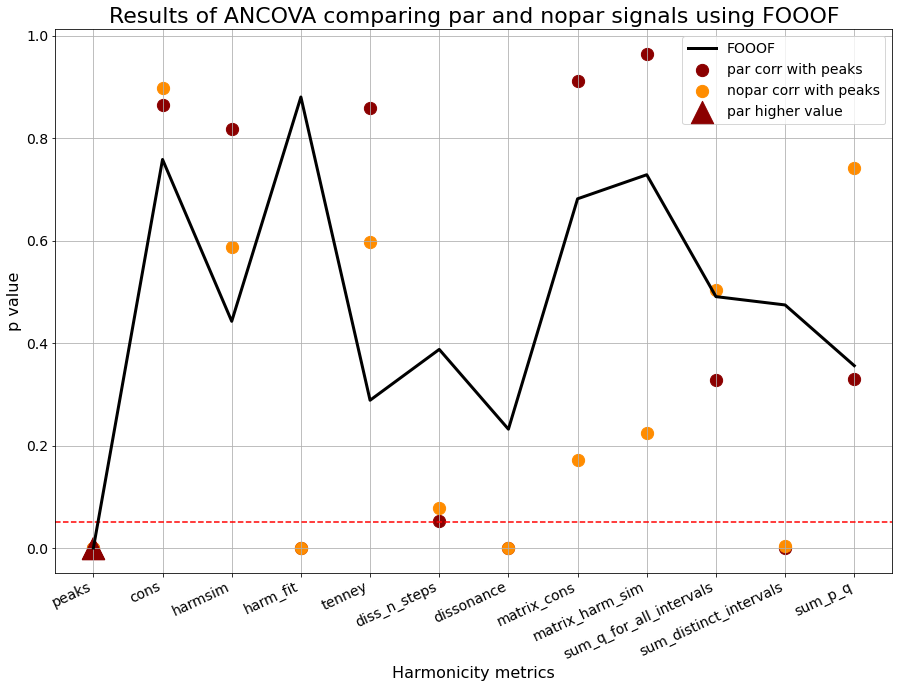

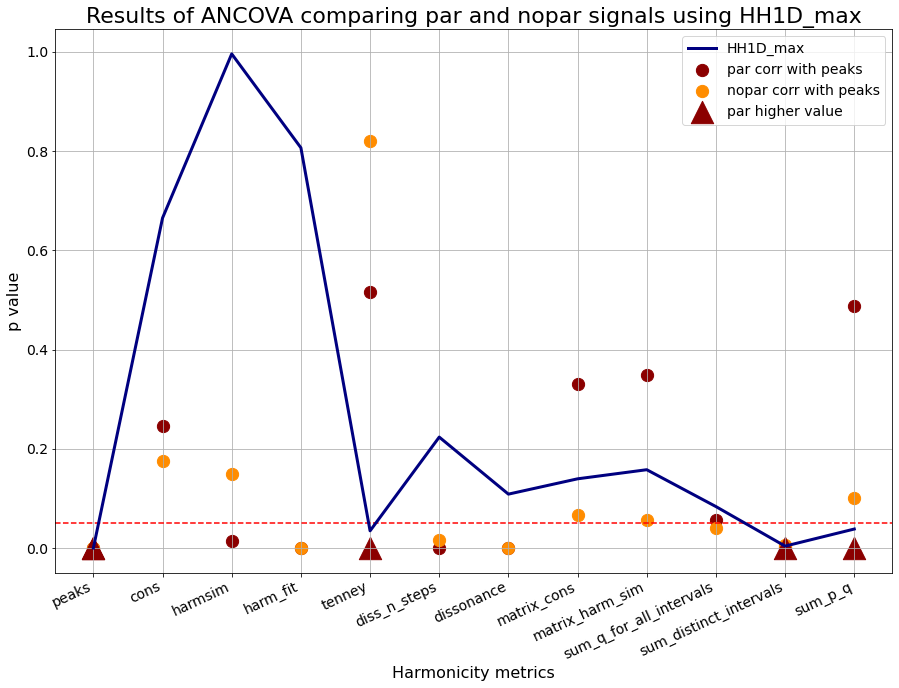

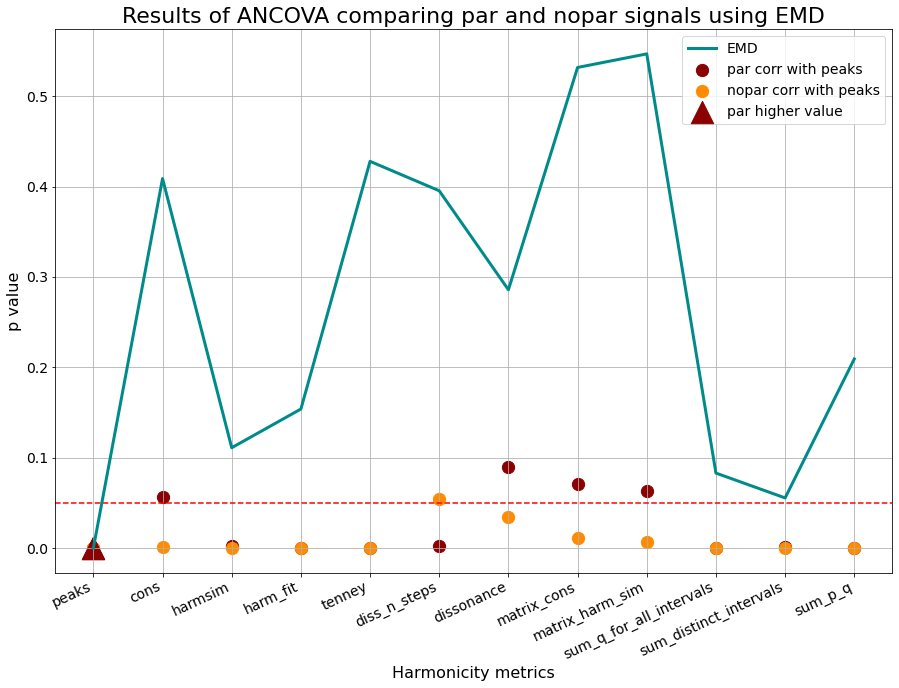

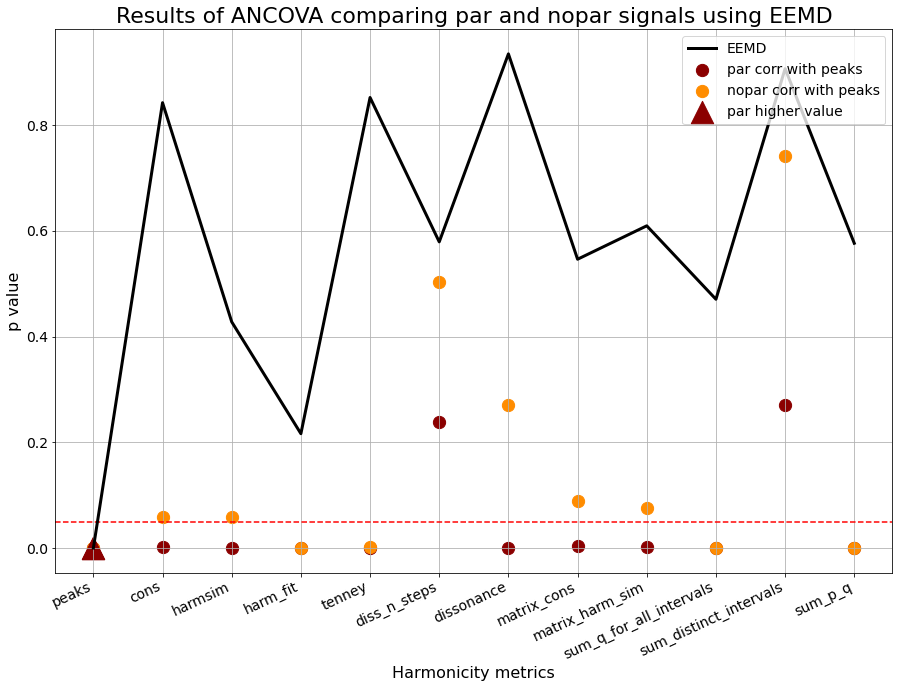

In [84]:
plt.rcParams['axes.facecolor'] = 'white'
ANCOVA_parNOpar, F_parNOpar, avg_all = ttest_all_metrics_all_functions(par_metrics, nopar_metrics, peaks_functions, data_types=['par', 'nopar'])
colors = ['darkcyan', 'black', 'navy','darkcyan', 'black', 'navy', 'darkcyan', 'black', 'navy']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ANCOVA_parNOpar, function, labels = ['par', 'nopar'], 
                           peaks_corr1=peaks_p_par, peaks_corr2=peaks_p_nopar, color=color, save=True, avg_all=avg_all)